# Identifying Semantic Similarities Between Proof-of-Concept Exploits and Known Exploited Vulnerabilities in Open-Source Software Using Type-4 Clone Detection

### BEP Jaime Ram - 5558581

---

## Project Structure

This notebook analyzes exploit code from ExploitDB to identify semantic similarities between Known Exploited Vulnerabilities (KEV) and non-KEV exploits using code clone detection techniques.

### Part 0: Setup
- **Step 0.1**: Install and import all required packages

### Part 1: Data Extraction & Cleaning
- **Step 1.1**: Extract ExploitDB data (2020-2025)
- **Step 1.2**: Download exploit code and extract CVEs
- **Step 1.3**: Combine CVEs and filter exploits
- **Step 1.4**: Open source filtering (OSV API)
- **Step 1.5**: Remove wrapper scripts (quality filter)

### Part 2: KEV Cross-Reference
- **Step 2.1**: Download VulnCheck KEV data
- **Step 2.2**: Cross-reference exploits with KEV database

### Part 3: Clone Detection Analysis
- **Step 3.1**: Parse exploit code (AST, normalization, Markov matrices)
- **Step 3.2**: Clone detection (Types 1-4)
- **Step 3.3**: Clone type comparison visualization

### Part 4: Payload Analysis
- **Step 4.1**: Payload string similarity analysis
- **Step 4.2**: Payload characteristic analysis

### Part 5: Visualization & Results
- **Step 5.1**: Similarity score distributions
- **Step 5.2**: High similarity pairs table
- **Step 5.3**: CVSS vs similarity correlation
- **Step 5.4**: Payload comparison (side-by-side)

---

## Data Flow

```
ExploitDB (2020-2025)
    ↓
CVE Extraction & Filtering
    ↓
Open Source Filtering (OSV API)
    ↓
Quality Filtering (Remove Wrappers)
    ↓
KEV Cross-Reference (VulnCheck)
    ↓
├── KEV Exploits (with CVE in KEV catalog)
└── Non-KEV Exploits (CVE not in KEV catalog)
    ↓
Code Parsing (AST, Markov)
    ↓
Clone Detection (4 Types)
    ↓
Analysis & Visualization
```

---

## Requirements

- Python 3.8+
- VulnCheck API key (free at https://vulncheck.com)
- Internet connection for API calls


---

# Part 0: Setup

---

### Step 0.1: Install and Import Required Packages

**Objective**: Install and import all dependencies needed for the analysis.

**What gets installed**:
- `tree-sitter-languages`: AST parsing for multiple programming languages
- `vulncheck-sdk`: Access to VulnCheck KEV database
- `seaborn`, `matplotlib`: Visualization
- `scikit-learn`, `scipy`: Machine learning and statistics
- `pandas`, `numpy`: Data manipulation

**What gets imported**:
- Standard library: `os`, `re`, `json`, `time`, `collections`, `difflib`, `warnings`
- Data science: `pandas`, `numpy`, `matplotlib`, `seaborn`
- ML/Stats: `sklearn`, `scipy`
- AST parsing: `tree_sitter_languages`
- APIs: `requests`, `vulncheck_sdk`

**Output**: All packages ready for use in subsequent steps.

In [ ]:
# ==============================================================================
# STEP 0.1: INSTALL AND IMPORT ALL REQUIRED PACKAGES
# ==============================================================================

import subprocess
import sys

# Install required packages
packages = [
    'tree-sitter-languages',
    'vulncheck-sdk', 
    'seaborn',
    'matplotlib',
    'scikit-learn',
    'scipy',
    'pandas',
    'numpy',
    'requests'
]

for package in packages:
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])
    except:
        pass

# ==============================================================================
# STANDARD LIBRARY IMPORTS
# ==============================================================================
import os
import re
import json
import time
import warnings
from collections import Counter, defaultdict
from difflib import SequenceMatcher

# ==============================================================================
# DATA SCIENCE IMPORTS
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# ==============================================================================
# MACHINE LEARNING & STATISTICS IMPORTS
# ==============================================================================
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import pearsonr, spearmanr, chi2_contingency, ttest_ind, mannwhitneyu

# ==============================================================================
# AST PARSING IMPORTS
# ==============================================================================
from tree_sitter_languages import get_language, get_parser

# ==============================================================================
# API IMPORTS
# ==============================================================================
import requests
import vulncheck_sdk

# ==============================================================================
# CONFIGURATION
# ==============================================================================
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['font.size'] = 10
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Create output directories
os.makedirs('outputs', exist_ok=True)
os.makedirs('outputs/Files', exist_ok=True)
os.makedirs('outputs/figures', exist_ok=True)

print(f"\nOutput directories created:")
print(f"  - outputs/")
print(f"  - outputs/Files/")
print(f"  - outputs/figures/")

---

# Part 1: Data Extraction & Cleaning

This part extracts exploit data from ExploitDB, downloads the actual exploit code, extracts CVEs, and applies quality filters.

---

### Step 1.1: Extract ExploitDB Data (2020-2025)

**Objective**: Download and filter ExploitDB metadata for exploits from 2020-2025.

**How it works**:
1. Download `files_exploits.csv` from ExploitDB GitLab repository
2. Parse the date column and filter for 2020-01-01 to 2025-12-31
3. Keep only relevant columns for analysis

**What happens**:
- Downloads ~50MB CSV file with all ExploitDB entries
- Filters to recent exploits (last 5 years)
- Creates initial DataFrame with exploit metadata

**Output**: `exploitdb_df` DataFrame with filtered exploit metadata.

In [ ]:
# ==============================================================================
# STEP 1.1: EXTRACT EXPLOITDB DATA (2020-2025)
# ==============================================================================

print("=" * 80)
print("STEP 1.1: EXTRACTING EXPLOITDB DATA")
print("=" * 80)

# Download ExploitDB data if not present
exploitdb_path = 'outputs/Files/files_exploits.csv'
exploitdb_url = 'https://gitlab.com/exploit-database/exploitdb/-/raw/main/files_exploits.csv'

if not os.path.exists(exploitdb_path):
    print(f'Downloading ExploitDB data from GitLab...')
    response = requests.get(exploitdb_url, timeout=60)
    response.raise_for_status()
    with open(exploitdb_path, 'wb') as f:
        f.write(response.content)
    print(f'Downloaded: {exploitdb_path}')
else:
    print(f'Using cached: {exploitdb_path}')

# Load and filter data
exploitdb_df = pd.read_csv(exploitdb_path)
print(f"\nTotal ExploitDB entries: {len(exploitdb_df):,}")

# Filter by date range (2020-2025)
exploitdb_df['date'] = pd.to_datetime(exploitdb_df['date'], errors='coerce')
exploitdb_df = exploitdb_df[
    (exploitdb_df['date'] >= '2020-01-01') & 
    (exploitdb_df['date'] <= '2025-12-31')
]

print(f"Exploits from 2020-2025: {len(exploitdb_df):,}")
print(f"\nColumns: {list(exploitdb_df.columns)}")
print(f"\nDate range: {exploitdb_df['date'].min()} to {exploitdb_df['date'].max()}")

### Step 1.2: Download Exploit Code and Extract CVEs

**Objective**: Download actual exploit source code and extract CVE identifiers.

**How it works**:
1. For each exploit, download the source code from ExploitDB
2. Parse code to find CVE references (regex: `CVE-\d{4}-\d+`)
3. Also extract CVEs from metadata `codes` column

**What happens**:
- Downloads exploit code files (cached locally)
- Extracts CVEs from both code content and metadata
- Adds `code_cves` column with CVEs found in source code

**Output**: `exploitdb_df` enriched with `code_cves` column.

In [ ]:
def download_exploit_code(file_path):
    """Download exploit code from ExploitDB GitLab repository"""
    if pd.isna(file_path) or file_path == '':
        return None
    
    # ExploitDB GitLab raw URL
    base_url = "https://gitlab.com/exploit-database/exploitdb/-/raw/main/"
    url = base_url + str(file_path)
    
    try:
        response = requests.get(url, timeout=15)
        if response.status_code == 200:
            return response.text
        else:
            return None
    except Exception as e:
        return None

def extract_cves_from_text(text):
    """Extract all CVEs from text using regex"""
    if not text:
        return []
    # Pattern matches: CVE-YYYY-NNNN+ (4+ digits after year)
    matches = re.findall(r'CVE-\d{4}-\d{4,}', str(text), re.IGNORECASE)
    # Normalize to uppercase and remove duplicates
    normalized = list(set([c.upper().strip() for c in matches]))
    return normalized

# Initialize columns
exploitdb_df['cves_from_codes'] = None  # CVEs from 'codes' column
exploitdb_df['cves_from_code'] = None  # CVEs extracted from exploit code
exploitdb_df['all_cves'] = None  # Combined CVEs

# First, extract CVEs from 'codes' column
print("\n1. Extracting CVEs from 'codes' column...")
for idx, row in exploitdb_df.iterrows():
    if pd.notna(row.get('codes')):
        cves = extract_cves_from_text(str(row['codes']))
        if cves:
            exploitdb_df.at[idx, 'cves_from_codes'] = cves

codes_cves_count = exploitdb_df['cves_from_codes'].notna().sum()
print(f"   Found CVEs in 'codes' column for {codes_cves_count:,} exploits")

# Second, download exploit code and extract CVEs
print("\n2. Downloading exploit code and extracting CVEs from code...")

code_cves_count = 0
downloaded_count = 0
failed_count = 0
cache = {}  # Cache for downloaded code

# Use enumerate to get proper counter instead of using idx
for counter, (idx, row) in enumerate(exploitdb_df.iterrows(), 1):
    file_path = row.get('file')
    
    if pd.isna(file_path) or file_path == '':
        failed_count += 1
        continue
    
    # Check cache first
    if file_path in cache:
        code = cache[file_path]
    else:
        code = download_exploit_code(file_path)
        cache[file_path] = code
        if code:
            downloaded_count += 1
        else:
            failed_count += 1
        # Rate limiting: small delay to avoid overwhelming the server
        time.sleep(0.05)  # 50ms delay between downloads
    
    if code:
        # Extract CVEs from the code
        cves = extract_cves_from_text(code)
        if cves:
            exploitdb_df.at[idx, 'cves_from_code'] = cves
            code_cves_count += 1
    
    # Progress reporting - use counter instead of idx
    if counter % 100 == 0:
        print(f"   Processed {counter:,}/{len(exploitdb_df):,} exploits... "
              f"(Downloaded: {downloaded_count:,}, Found CVEs: {code_cves_count:,}, Failed: {failed_count:,})")

print(f"   - Successfully downloaded: {downloaded_count:,} exploit files")
print(f"   - Found CVEs in code for: {code_cves_count:,} exploits")

### Step 1.3: Combine CVEs and Filter Exploits

**Objective**: Combine CVEs from metadata and code, then keep only exploits with CVEs.

**How it works**:
1. Combine CVEs from `codes` column (metadata) and `code_cves` (from source)
2. Store combined CVEs in `all_cves` column
3. **FILTER**: Remove exploits without any CVE

**Why filter on CVE**:
- All subsequent analysis is CVE-based
- KEV database is 100% CVE-based
- No point processing exploits we can't match

**Output**: `exploitdb_df` containing only exploits with CVEs.

In [ ]:
# Combine CVEs from metadata and code into 'all_cves' column, then remove entries without CVEs

print("="*80)
print("STEP 1.3: COMBINE CVEs AND FILTER")
print("="*80)

input_count = len(exploitdb_df)
print(f"\n INPUT: {input_count:,} exploits")

# Build all_cves column: combine CVEs from metadata (cves_from_codes) and code (cves_from_code)
for idx, row in exploitdb_df.iterrows():
    cves = set()

    for col in ['cves_from_codes', 'cves_from_code']:
        val = row.get(col)
        if isinstance(val, list):
            cves.update([c.upper().strip() for c in val if c])
        elif val is not None and not pd.isna(val):
            cves.update([c.upper().strip() for c in extract_cves_from_text(str(val)) if c])

    exploitdb_df.at[idx, 'all_cves'] = sorted(cves) if cves else None

# Remove entries without CVEs
exploitdb_df = exploitdb_df[exploitdb_df['all_cves'].notna()].copy()

output_count = len(exploitdb_df)
print(f" OUTPUT: {output_count:,} exploits (all have CVEs)")
print(f" REMOVED: {input_count - output_count:,} exploits (no CVE)")
print(f"\n exploitdb_df now contains ONLY exploits with CVEs")

### Step 1.4: Open Source Filtering (OSV API)

**Objective**: Keep only exploits targeting open-source software.

**How it works**:
1. **Via OSV API**: If the CVE is found in OSV database → confirmed open-source
2. **Via Platform**: If platform indicates open-source (Linux, PHP, Python, etc.)

**What happens**:
- Query OSV API for each unique CVE
- Enrich with OSV metadata (summary, severity, affected packages)
- **FILTER**: Remove all non-open-source exploits

**Output**: `exploitdb_df` containing only open-source exploits.

In [ ]:
# Open Source Filtering - Keep only open-source exploits

OSV_API_BASE = "https://api.osv.dev/v1"

def query_osv_by_cve(cve_id):
    """Query OSV API for a specific CVE"""
    url = f"{OSV_API_BASE}/vulns/{cve_id}"
    try:
        r = requests.get(url, timeout=10)
        return r.json() if r.status_code == 200 else None
    except Exception:
        return None

def is_opensource_platform(platform):
    """Check if platform indicates open source"""
    if pd.isna(platform):
        return False
    platform_lower = str(platform).lower()
    opensource_indicators = [
        'linux', 'unix', 'php', 'python', 'ruby', 'node', 'java',
        'apache', 'nginx', 'mysql', 'postgresql', 'mongodb',
        'wordpress', 'drupal', 'joomla', 'openssl', 'curl', 'git',
        'multiple', 'webapps'
    ]
    return any(indicator in platform_lower for indicator in opensource_indicators)

print("="*80)
print("STEP 4: OPEN SOURCE FILTERING")
print("="*80)

# Input count
input_count = len(exploitdb_df)
print(f"\n INPUT: {input_count:,} exploits (with CVEs from Step 3)")

# Extract unique CVEs for OSV lookup
print("\n1. Extracting unique CVEs for OSV lookup...")
unique_cves = set()
for idx, row in exploitdb_df.iterrows():
    all_cves = row.get('all_cves')
    if isinstance(all_cves, list):
        unique_cves.update(all_cves)
print(f"   Found {len(unique_cves):,} unique CVEs to check")

# Query OSV API
print(f"\n2. Querying OSV API for {len(unique_cves):,} CVEs...")
osv_data = {}
osv_found_count = 0
for i, cve in enumerate(unique_cves, 1):
    if i % 100 == 0:
        print(f"   Processed {i}/{len(unique_cves)} CVEs...")
    data = query_osv_by_cve(cve)
    if data and 'id' in data:
        osv_data[cve] = data
        osv_found_count += 1
print(f"   Found {osv_found_count:,} CVEs in OSV database")

# Mark and enrich exploits
print("\n3. Marking open-source exploits and enriching with OSV data...")
exploitdb_df['OpenSource'] = None
exploitdb_df['osv_summary'] = None
exploitdb_df['osv_severity'] = None
exploitdb_df['osv_affected'] = None

by_osv = 0
by_platform = 0

for idx, row in exploitdb_df.iterrows():
    # Get CVEs for this exploit
    all_cves = row.get('all_cves')
    if not isinstance(all_cves, list):
        all_cves = []

    # Check if any CVE is in OSV
    found_in_osv = False
    for cve in all_cves:
        if cve in osv_data:
            found_in_osv = True
            osv_info = osv_data[cve]
            if 'summary' in osv_info:
                exploitdb_df.at[idx, 'osv_summary'] = osv_info['summary']
            if 'severity' in osv_info:
                exploitdb_df.at[idx, 'osv_severity'] = json.dumps(osv_info['severity'])
            if 'affected' in osv_info:
                exploitdb_df.at[idx, 'osv_affected'] = json.dumps(osv_info['affected'])
            break

    # Set OpenSource column
    if found_in_osv:
        exploitdb_df.at[idx, 'OpenSource'] = 'byOSV'
        by_osv += 1
    elif is_opensource_platform(row.get('platform')):
        exploitdb_df.at[idx, 'OpenSource'] = 'byPlatform'
        by_platform += 1

# FILTER: Keep only open-source exploits
print("\n4. FILTERING: Keeping only open-source exploits...")
exploitdb_df = exploitdb_df[exploitdb_df['OpenSource'].notna()].copy()

# Save a copy of the full open-source dataset for later comparison
opensource_full_df = exploitdb_df.copy()

# Output summary
output_count = len(exploitdb_df)
removed_count = input_count - output_count

print(f"\n{'='*80}")
print(f"STEP 4 COMPLETE")
print(f"{'='*80}")
print(f"\n INPUT:  {input_count:,} exploits")
print(f" OUTPUT: {output_count:,} exploits")
print(f" REMOVED: {removed_count:,} exploits (not open-source)")
print(f"\nBreakdown of open-source exploits:")
print(f"  - Via OSV API:  {by_osv:,} exploits")
print(f"  - Via Platform: {by_platform:,} exploits")
print(f"\n exploitdb_df now contains ONLY open-source exploits")
print(f"{'='*80}")

### Step 1.5: Remove Wrapper Scripts (Quality Filter)

**Objective**: Remove wrapper scripts that just call external tools.

**How it works**:
- Detect scripts that call sqlmap, metasploit, nmap, etc.
- Detect scripts with no actual exploit implementation
- Detect very small scripts (<100 characters)

**What gets removed**:
- Scripts that are just tool wrappers
- Scripts with no actual vulnerability exploitation code
- Placeholder or stub scripts

**What we keep**:
- Real exploit implementations with actual code
- Scripts with functions/classes OR HTTP requests

**Output**: `exploitdb_df` containing only real exploit implementations.

In [ ]:
# Remove Wrapper Scripts - Keep only real exploit implementations
# NOTE: No quality score filtering - only wrapper detection!

import sys
import ast

warnings.filterwarnings('ignore', category=SyntaxWarning)

print("="*80)
print("STEP 5: REMOVE WRAPPER SCRIPTS")
print("="*80)

# Input count
input_count = len(exploitdb_df)
print(f"\n INPUT: {input_count:,} exploits (open-source from Step 4)")

# Download function
def download_exploit_code(file_path):
    """Download exploit code from ExploitDB"""
    if pd.isna(file_path) or not file_path:
        return None
    base_url = "https://gitlab.com/exploit-database/exploitdb/-/raw/main/"
    url = f"{base_url}{file_path}"
    try:
        response = requests.get(url, timeout=15)
        if response.status_code == 200:
            return response.text
    except:
        pass
    return None

def is_wrapper_script(code, file_path=""):
    """Detect if exploit is a wrapper script (should be excluded)"""
    if not code or len(code.strip()) < 100:
        return True, "too_small"

    # External tool calls
    external_tools = [
        'sqlmap', 'metasploit', 'msfvenom', 'msfconsole',
        'nmap', 'nikto', 'burp', 'hydra', 'john',
        'aircrack', 'hashcat', 'wpscan', 'dirbuster',
        'gobuster', 'ffuf', 'wfuzz'
    ]

    code_lower = code.lower()
    calls_external = any(tool in code_lower for tool in external_tools) and any([
        'os.system' in code,
        'subprocess.call' in code,
        'subprocess.run' in code,
        'subprocess.Popen' in code,
        'os.popen' in code,
    ])

    if calls_external:
        return True, "external_tool"

    # Check for actual implementation
    has_implementation = False

    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tree = ast.parse(code)
        functions = [n for n in ast.walk(tree) if isinstance(n, ast.FunctionDef)]
        classes = [n for n in ast.walk(tree) if isinstance(n, ast.ClassDef)]
        has_implementation = len(functions) > 0 or len(classes) > 0
    except:
        has_implementation = (
            'function ' in code or
            'def ' in code or
            'class ' in code or
            'requests.' in code or
            'urllib' in code or
            'http.client' in code or
            'socket.' in code
        )

    if not has_implementation:
        has_http = bool(re.search(r'requests\.(get|post|put|delete)|urllib|http\.client', code))
        if has_http:
            has_implementation = True

    if not has_implementation:
        return True, "no_implementation"

    return False, "ok"

# Process exploits
print("\nAnalyzing exploits for wrapper scripts...")
keep_indices = []
removed = {"too_small": 0, "external_tool": 0, "no_implementation": 0, "no_code": 0}

total = len(exploitdb_df)
for i, (idx, row) in enumerate(exploitdb_df.iterrows(), 1):
    if i % 100 == 0:
        print(f"   Processed {i}/{total} exploits...")

    file_path = row.get('file', '')
    code = download_exploit_code(file_path)

    if not code:
        removed["no_code"] += 1
        continue

    is_wrapper, reason = is_wrapper_script(code, file_path)

    if is_wrapper:
        removed[reason] += 1
    else:
        keep_indices.append(idx)

# Filter dataframe
exploitdb_df = exploitdb_df.loc[keep_indices].copy()

# Output summary
output_count = len(exploitdb_df)
total_removed = input_count - output_count

print(f"\n{'='*80}")
print(f"STEP 5 COMPLETE")
print(f"{'='*80}")
print(f"\n INPUT:  {input_count:,} exploits")
print(f" OUTPUT: {output_count:,} exploits")
print(f" REMOVED: {total_removed:,} wrapper scripts")
print(f"\nRemoval breakdown:")
print(f"  - Too small (<100 chars):  {removed['too_small']:,}")
print(f"  - External tool wrappers:  {removed['external_tool']:,}")
print(f"  - No implementation:       {removed['no_implementation']:,}")
print(f"  - Could not download:      {removed['no_code']:,}")
print(f"\n exploitdb_df now contains ONLY real exploit implementations")
print(f"{'='*80}")

# For compatibility with later steps
enriched_df = exploitdb_df.copy()

---

# Part 2: KEV Cross-Reference

This part downloads the Known Exploited Vulnerabilities (KEV) catalog and cross-references our filtered exploits.

---

### Step 2.1: Download VulnCheck KEV Data

**Objective**: Download the VulnCheck KEV catalog containing known exploited vulnerabilities.

**How it works**:
1. Use VulnCheck SDK to access their KEV API
2. Download full catalog of known exploited vulnerabilities
3. Cache locally to avoid repeated API calls

**What is KEV**:
- CISA's catalog of vulnerabilities with confirmed exploitation in the wild
- Contains CVE IDs, vendor info, due dates for remediation
- VulnCheck enriches this with additional metadata

**API Key Required**: 
- Get free API key at https://vulncheck.com
- Set as environment variable or in code

**Output**: `kev_df` DataFrame with KEV catalog data.

In [ ]:
# Download Vulncheck KEV catalog using SDK

# Install vulncheck_sdk if not already installed
%pip install vulncheck-sdk -q

print("Downloading Vulncheck KEV catalog...")
VULNCHECK_API_KEY = "vulncheck_a50222ddd96c3e8cdd7f7e1fd30f1bcf61afa60cd1304a5028f337067af88243"

configuration = vulncheck_sdk.Configuration(host="https://api.vulncheck.com/v3")
configuration.api_key["Bearer"] = VULNCHECK_API_KEY
configuration.verify_ssl = False  # Disable SSL verification to avoid certificate issues

print("   Getting KEV backup URL from Vulncheck API...")
with vulncheck_sdk.ApiClient(configuration) as api_client:
    endpoints_client = vulncheck_sdk.EndpointsApi(api_client)
    
    # Get the backup URL
    api_response = endpoints_client.backup_index_get("vulncheck-kev")
    
    if not api_response.data or len(api_response.data) == 0:
        raise ValueError("No backup URL returned from API")
    
    backup_url = api_response.data[0].url
    print(f"   Backup URL retrieved: {backup_url}")
    
    # Download the backup file (it's a ZIP file)
    print(f"   Downloading KEV entries from backup URL (this may take a while)...")
    response = requests.get(backup_url, timeout=300, verify=False)  # Longer timeout for large file
    response.raise_for_status()
    
    # The backup is a ZIP file, extract and parse JSON
    import zipfile
    import io
    
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
        # Find the JSON file in the ZIP
        json_files = [f for f in zip_file.namelist() if f.endswith('.json')]
        if not json_files:
            raise ValueError("No JSON file found in ZIP archive")
        
        # Read the first JSON file (usually there's only one)
        json_file = json_files[0]
        print(f"   Extracting JSON from: {json_file}")
        with zip_file.open(json_file) as f:
            all_kev_entries = json.load(f)
    
    print(f"\n   Retrieved {len(all_kev_entries):,} Vulncheck KEV entries")

# Convert to DataFrame
kev_df = pd.DataFrame(all_kev_entries)
print(f"   Total KEV entries: {len(kev_df):,}")

print(f"   Columns: {list(kev_df.columns)}")
kev_df.head()

### Step 2.2: Cross-Reference Exploits with KEV Database

**Objective**: Identify which exploits target Known Exploited Vulnerabilities.

**How it works**:
1. Match CVEs from filtered exploits against KEV catalog
2. Label exploits as KEV (CVE in catalog) or non-KEV
3. Create separate samples for comparison

**What happens**:
- Creates `is_kev` boolean column
- Splits data into `kev_sample` and `non_kev_sample`
- These samples will be compared in clone detection

**Output**: 
- `kev_sample`: Exploits targeting known exploited vulnerabilities
- `non_kev_sample`: Exploits targeting other vulnerabilities

In [ ]:
# Cross-reference CVEs with KEV database

print("="*80)
print("STEP 2.2: KEV CROSS-REFERENCE")
print("="*80)

# Input count
input_count = len(exploitdb_df)
print(f"\n INPUT: {input_count:,} exploits (wrapper-free from Step 5)")

# Check requirements
if 'kev_df' not in globals():
    raise NameError("kev_df not found. Please run Step 6 first.")

# Helper functions
def extract_cves_from_text(text):
    if not text:
        return []
    matches = re.findall(r'CVE-\d{4}-\d{4,}', str(text), re.IGNORECASE)
    return list(set([c.upper().strip() for c in matches]))

def get_cves_from_row(row):
    cves_list = []
    all_cves = row.get('all_cves')
    if all_cves is not None and isinstance(all_cves, list):
        cves_list.extend([c.upper().strip() for c in all_cves if c])
    if not cves_list:
        codes = row.get('codes')
        if codes is not None and pd.notna(codes):
            cves_list.extend(extract_cves_from_text(str(codes)))
    return list(set(cves_list))

# 1. Extract KEV CVEs
print("\n1. Extracting CVEs from KEV database...")
kev_cves = set()
for idx, row in kev_df.iterrows():
    cves = row.get('cve', [])
    if isinstance(cves, list):
        for cve in cves:
            if cve and isinstance(cve, str):
                kev_cves.add(cve.upper().strip())
    elif cves and isinstance(cves, str):
        kev_cves.add(cves.upper().strip())
print(f"   Found {len(kev_cves):,} unique CVEs in KEV database")

# 2. Extract exploit CVEs
print("\n2. Extracting CVEs from exploit dataset...")
exploit_cves = set()
for idx, row in exploitdb_df.iterrows():
    cves = get_cves_from_row(row)
    exploit_cves.update(cves)
print(f"   Found {len(exploit_cves):,} unique CVEs in exploit dataset")

# 3. Find matching CVEs
print("\n3. Finding matching CVEs...")
matching_cves = exploit_cves.intersection(kev_cves)
print(f"   CVEs in BOTH datasets: {len(matching_cves):,}")

# 4. Mark exploits
print("\n4. Marking exploits as KEV or non-KEV...")
exploitdb_df['in_kev'] = False
exploitdb_df['kev_cves'] = None

for idx, row in exploitdb_df.iterrows():
    cves = get_cves_from_row(row)
    row_kev_cves = [cve for cve in cves if cve in kev_cves]
    if row_kev_cves:
        exploitdb_df.at[idx, 'in_kev'] = True
        exploitdb_df.at[idx, 'kev_cves'] = row_kev_cves

# 5. Split into KEV and non-KEV
found_kev_df = exploitdb_df[exploitdb_df['in_kev'] == True].copy()
not_found_kev_df = exploitdb_df[exploitdb_df['in_kev'] == False].copy()

# Output summary
print(f"\n{'='*80}")
print(f"STEP 7 COMPLETE")
print(f"{'='*80}")
print(f"\n INPUT:  {input_count:,} exploits")
print(f"\n OUTPUT (split into two groups):")
print(f"   KEV exploits:     {len(found_kev_df):,} (CVE found in KEV)")
print(f"   Non-KEV exploits: {len(not_found_kev_df):,} (CVE not in KEV)")
print(f"\nMatching statistics:")
print(f"   - Unique CVEs in exploits: {len(exploit_cves):,}")
print(f"   - Unique CVEs in KEV:      {len(kev_cves):,}")
print(f"   - Overlapping CVEs:        {len(matching_cves):,}")
print(f"\n found_kev_df contains KEV exploits")
print(f" not_found_kev_df contains non-KEV exploits")
print(f"{'='*80}")

# Show samples
print("\nSample KEV exploits:")
for idx, row in found_kev_df.head(5).iterrows():
    cves = ', '.join(row.get('kev_cves', [])[:2]) if row.get('kev_cves') else 'N/A'
    print(f"  - ID {row.get('id')}: {cves}")

---

# Part 3: Clone Detection Analysis

This part parses exploit code and performs clone detection using four different methods based on the code clone taxonomy.

**Clone Types** (Bellon et al., 2007):
- **Type-1 (Textual)**: Identical code except whitespace, layout, comments
- **Type-2 (Lexical)**: Identical except identifier names and literal values  
- **Type-3 (Syntactic)**: Similar at statement level with added/modified/removed statements
- **Type-4 (Semantic)**: Different syntax but same functionality

---

### Step 3.1: Parse Exploit Code

**Objective**: Parse all exploit code and prepare data structures for clone detection.

**How it works**:
1. **Raw code**: Store original exploit source
2. **Type-1 normalized**: Remove whitespace, comments, normalize indentation
3. **Type-2 normalized**: Replace identifiers/literals with placeholders
4. **AST sequence**: Extract Abstract Syntax Tree node types
5. **Markov matrix**: Build state transition matrix from AST

**What happens**:
- Uses tree-sitter for language-agnostic AST parsing
- Supports Python, C, PHP, Ruby, JavaScript, Bash, Java, Go
- Creates standardized data structures for each exploit

**Output**: 
- `parsed_kev`: Parsed data for KEV exploits
- `parsed_non_kev`: Parsed data for non-KEV exploits

In [ ]:
# Step 3.1: Parse Exploit Code for Clone Detection
# Prepares all data structures needed for Type-1 to Type-4 similarity analysis

# Check prerequisites
if 'found_kev_df' not in globals() or 'not_found_kev_df' not in globals():
    raise NameError("found_kev_df or not_found_kev_df not found. Run Step 7 first.")

print("="*80)
print("STEP 7b: PARSE EXPLOIT CODE")
print("="*80)

# Install tree-sitter if needed
%pip install -q tree-sitter-java tree-sitter-go tree-sitter-rust

# ============================================================================
# TREE-SITTER INITIALIZATION
# ============================================================================

LANG_AVAILABLE = {}
LANG_MODULES = {}

try:
    TREE_SITTER_LANGUAGES_AVAILABLE = True
except ImportError:
    TREE_SITTER_LANGUAGES_AVAILABLE = False

LANGUAGE_CONFIGS = [
    ('python', 'tree_sitter_python', 'python'),
    ('c', 'tree_sitter_c', 'c'),
    ('ruby', 'tree_sitter_ruby', 'ruby'),
    ('php', 'tree_sitter_php', 'php'),
    ('javascript', 'tree_sitter_javascript', 'javascript'),
    ('java', 'tree_sitter_java', 'java'),
    ('go', 'tree_sitter_go', 'go'),
    ('rust', 'tree_sitter_rust', 'rust'),
    ('perl', None, 'perl'),
    ('bash', None, 'bash'),
]

for lang_name, module_name, ts_lang_name in LANGUAGE_CONFIGS:
    lang_available = False
    if TREE_SITTER_LANGUAGES_AVAILABLE:
        try:
            get_language(ts_lang_name)
            lang_available = True
            LANG_MODULES[lang_name] = ts_lang_name
        except:
            pass
    if not lang_available and module_name:
        try:
            LANG_MODULES[lang_name] = __import__(module_name)
            lang_available = True
        except ImportError:
            pass
    LANG_AVAILABLE[lang_name] = lang_available

print(f"Available languages: {[l for l, a in LANG_AVAILABLE.items() if a]}")

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def get_exploit_code(row):
    """Get exploit code from local file or download from GitLab"""
    if 'code_file' in row.index:
        code_file = row.get('code_file')
        if pd.notna(code_file) and code_file and os.path.exists(str(code_file)):
            try:
                with open(str(code_file), 'r', encoding='utf-8') as f:
                    return f.read()
            except:
                pass
    file_path = row.get('file')
    if pd.isna(file_path) or not file_path:
        return None
    file_path_str = str(file_path).strip()
    if not file_path_str:
        return None
    url = f"https://gitlab.com/exploit-database/exploitdb/-/raw/main/{file_path_str}"
    try:
        response = requests.get(url, timeout=15)
        if response.status_code == 200:
            return response.text
    except:
        pass
    return None

def detect_language(file_path):
    """Detect programming language from file extension"""
    if pd.isna(file_path) or not file_path:
        return None
    path = str(file_path).lower()
    if '.' not in path:
        return None
    ext = path.split('.')[-1]
    lang_map = {
        'py': 'python', 'pyw': 'python',
        'rb': 'ruby', 'rake': 'ruby',
        'php': 'php', 'phtml': 'php',
        'js': 'javascript', 'jsx': 'javascript', 'mjs': 'javascript',
        'c': 'c', 'cpp': 'c', 'cc': 'c', 'cxx': 'c', 'h': 'c', 'hpp': 'c',
        'java': 'java',
        'go': 'go',
        'rs': 'rust',
        'pl': 'perl', 'pm': 'perl',
        'sh': 'bash', 'bash': 'bash', 'zsh': 'bash'
    }
    lang = lang_map.get(ext)
    if lang == 'python':
        return 'python'
    return lang if lang and LANG_AVAILABLE.get(lang) else None

# ============================================================================
# TYPE-1: TEXT NORMALIZATION (remove whitespace and comments)
# ============================================================================

COMMENT_PATTERNS = {
    'python': (r'#.*?$', r'"""[\s\S]*?"""', r"'''[\s\S]*?'''"),
    'c': (r'//.*?$', r'/\*[\s\S]*?\*/'),
    'javascript': (r'//.*?$', r'/\*[\s\S]*?\*/'),
    'java': (r'//.*?$', r'/\*[\s\S]*?\*/'),
    'php': (r'//.*?$', r'#.*?$', r'/\*[\s\S]*?\*/'),
    'ruby': (r'#.*?$', r'=begin[\s\S]*?=end'),
    'go': (r'//.*?$', r'/\*[\s\S]*?\*/'),
    'rust': (r'//.*?$', r'/\*[\s\S]*?\*/'),
    'perl': (r'#.*?$', r'=pod[\s\S]*?=cut'),
    'bash': (r'#.*?$',),
}

def normalize_for_type1(code, language):
    """Normalize code for Type-1 similarity: remove comments and whitespace"""
    if not code:
        return ''
    normalized = code
    patterns = COMMENT_PATTERNS.get(language, COMMENT_PATTERNS.get('python', ()))
    for pattern in patterns:
        normalized = re.sub(pattern, '', normalized, flags=re.MULTILINE)
    normalized = re.sub(r'[ \t]+', ' ', normalized)
    normalized = re.sub(r'\n\s*\n', '\n', normalized)
    normalized = '\n'.join(line.strip() for line in normalized.split('\n') if line.strip())
    return normalized

# ============================================================================
# TYPE-2: LEXICAL NORMALIZATION (replace identifiers and literals)
# ============================================================================

KEYWORDS = {
    'python': {'False', 'None', 'True', 'and', 'as', 'assert', 'async', 'await',
               'break', 'class', 'continue', 'def', 'del', 'elif', 'else', 'except',
               'finally', 'for', 'from', 'global', 'if', 'import', 'in', 'is',
               'lambda', 'nonlocal', 'not', 'or', 'pass', 'raise', 'return', 'try',
               'while', 'with', 'yield', 'print', 'open', 'range', 'len', 'str', 'int'},
    'javascript': {'break', 'case', 'catch', 'const', 'continue', 'debugger',
                   'default', 'delete', 'do', 'else', 'export', 'extends', 'finally',
                   'for', 'function', 'if', 'import', 'in', 'instanceof', 'let', 'new',
                   'return', 'switch', 'this', 'throw', 'try', 'typeof', 'var', 'void',
                   'while', 'with', 'yield', 'class', 'await', 'async'},
    'c': {'auto', 'break', 'case', 'char', 'const', 'continue', 'default', 'do',
          'double', 'else', 'enum', 'extern', 'float', 'for', 'goto', 'if', 'int',
          'long', 'register', 'return', 'short', 'signed', 'sizeof', 'static',
          'struct', 'switch', 'typedef', 'union', 'unsigned', 'void', 'volatile', 'while'},
}

def normalize_for_type2(code, language):
    """Normalize code for Type-2: replace identifiers and literals with placeholders"""
    if not code:
        return ''
    code = normalize_for_type1(code, language)
    keywords = KEYWORDS.get(language, KEYWORDS.get('python', set()))
    code = re.sub(r'"(?:[^"\\]|\\.)*"', '"STR"', code)
    code = re.sub(r"'(?:[^'\\]|\\.)*'", "'STR'", code)
    code = re.sub(r'\b\d+\.\d+\b', 'NUM', code)
    code = re.sub(r'\b\d+\b', 'NUM', code)
    code = re.sub(r'0x[0-9a-fA-F]+', 'HEX', code)
    def replace_identifier(match):
        word = match.group(0)
        if word in keywords:
            return word
        return 'ID'
    code = re.sub(r'\b[a-zA-Z_][a-zA-Z0-9_]*\b', replace_identifier, code)
    return code

# ============================================================================
# TYPE-3 & TYPE-4: AST PARSING
# ============================================================================

NUM_AST_TYPES = 57
NUM_TOKEN_TYPES = 15
TOTAL_TYPES = 72

UNIFIED_NODE_TYPES = {
    'function': 0, 'method': 1, 'if': 2, 'else': 3, 'for': 4, 'while': 5,
    'return': 6, 'break': 7, 'continue': 8, 'try': 9, 'except': 10, 'catch': 11,
    'assignment': 12, 'call': 13, 'identifier': 14, 'literal': 15, 'operator': 16,
    'binary': 17, 'unary': 18, 'ternary': 19, 'list': 20, 'dictionary': 21,
    'tuple': 22, 'array': 23, 'object': 24, 'variable': 25, 'parameter': 26,
    'class': 27, 'module': 28, 'block': 29, 'statement': 30, 'expression': 31,
    'string': 32, 'number': 33, 'comment': 34, 'import': 35, 'require': 36
}

def map_node_to_unified_type(node_type, language):
    """Map language-specific AST node type to unified type"""
    if not node_type:
        return 'statement'
    node_lower = str(node_type).lower()
    if 'function' in node_lower or 'method' in node_lower or 'def' in node_lower:
        return 'function'
    elif 'if' in node_lower:
        return 'if'
    elif 'else' in node_lower:
        return 'else'
    elif 'for' in node_lower:
        return 'for'
    elif 'while' in node_lower:
        return 'while'
    elif 'return' in node_lower:
        return 'return'
    elif 'break' in node_lower:
        return 'break'
    elif 'continue' in node_lower:
        return 'continue'
    elif 'try' in node_lower:
        return 'try'
    elif 'except' in node_lower or 'catch' in node_lower:
        return 'except'
    elif 'call' in node_lower or 'invocation' in node_lower:
        return 'call'
    elif 'assignment' in node_lower or 'assign' in node_lower:
        return 'assignment'
    elif 'identifier' in node_lower or 'name' in node_lower:
        return 'identifier'
    elif 'literal' in node_lower or 'constant' in node_lower or 'string' in node_lower or 'number' in node_lower:
        return 'literal'
    elif 'operator' in node_lower or 'binary' in node_lower:
        return 'operator'
    elif 'list' in node_lower or 'array' in node_lower:
        return 'list'
    elif 'dict' in node_lower or 'map' in node_lower:
        return 'dictionary'
    elif 'tuple' in node_lower:
        return 'tuple'
    elif 'class' in node_lower:
        return 'class'
    elif 'import' in node_lower or 'require' in node_lower:
        return 'import'
    elif 'module' in node_lower:
        return 'module'
    elif 'block' in node_lower:
        return 'block'
    elif 'expression' in node_lower:
        return 'expression'
    elif 'statement' in node_lower:
        return 'statement'
    else:
        return 'statement'

def parse_code_to_ast(code, language):
    """Parse code to AST using tree-sitter"""
    if not code or not language:
        return None
    if language == 'python':
        if LANG_AVAILABLE.get('python') and TREE_SITTER_LANGUAGES_AVAILABLE:
            try:
                parser = get_parser('python')
                if parser:
                    tree = parser.parse(bytes(code, 'utf8'))
                    if tree and tree.root_node:
                        return tree.root_node
            except:
                pass
        try:
            import ast as py_ast
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                tree = py_ast.parse(code)
            class SimpleNode:
                def __init__(self, node_type):
                    self.type = node_type
                    self.children = []
            def ast_to_simple_node(ast_node):
                if ast_node is None:
                    return None
                node_type = type(ast_node).__name__
                simple_node = SimpleNode(node_type)
                for field_name, field_value in py_ast.iter_fields(ast_node):
                    if isinstance(field_value, list):
                        for item in field_value:
                            if isinstance(item, py_ast.AST):
                                child = ast_to_simple_node(item)
                                if child:
                                    simple_node.children.append(child)
                    elif isinstance(field_value, py_ast.AST):
                        child = ast_to_simple_node(field_value)
                        if child:
                            simple_node.children.append(child)
                return simple_node
            root = SimpleNode('module')
            for child in py_ast.iter_child_nodes(tree):
                simple_child = ast_to_simple_node(child)
                if simple_child:
                    root.children.append(simple_child)
            return root
        except:
            return None
    if LANG_AVAILABLE.get(language):
        if TREE_SITTER_LANGUAGES_AVAILABLE:
            try:
                parser = get_parser(LANG_MODULES[language])
                if parser:
                    tree = parser.parse(bytes(code, 'utf8'))
                    if tree and tree.root_node:
                        return tree.root_node
            except:
                pass
        try:
            parser = Parser()
            lang_module = LANG_MODULES[language]
            if not isinstance(lang_module, str):
                parser.set_language(Language(lang_module.language()))
                tree = parser.parse(bytes(code, 'utf8'))
                if tree and tree.root_node:
                    return tree.root_node
        except:
            pass
    return None

def get_ast_node_sequence(ast_node):
    """Get sequence of AST node types for Type-3 similarity"""
    sequence = []
    def traverse(node):
        if not node:
            return
        if hasattr(node, 'type'):
            node_type = map_node_to_unified_type(str(node.type), 'python')
            sequence.append(node_type)
        if hasattr(node, 'children'):
            for child in node.children:
                traverse(child)
    traverse(ast_node)
    return sequence

def build_markov_matrix_from_ast(ast_node):
    """Build Markov chain transition matrix from AST for Type-4 similarity"""
    matrix = np.zeros((NUM_AST_TYPES, TOTAL_TYPES), dtype=np.float64)
    if not ast_node:
        return matrix
    def traverse(node, parent_type=None):
        if not node:
            return
        if hasattr(node, 'type'):
            node_type_str = str(node.type) if node.type else 'statement'
        else:
            node_type_str = 'statement'
        node_type = map_node_to_unified_type(node_type_str, 'python')
        parent_unified = map_node_to_unified_type(parent_type, 'python') if parent_type else None
        node_idx = UNIFIED_NODE_TYPES.get(node_type, hash(node_type) % NUM_AST_TYPES) % NUM_AST_TYPES
        if hasattr(node, 'children'):
            children = node.children
        else:
            children = []
        for child in children:
            if child is None:
                continue
            if hasattr(child, 'type'):
                child_type_str = str(child.type) if child.type else 'statement'
            else:
                child_type_str = 'statement'
            child_type = map_node_to_unified_type(child_type_str, 'python')
            child_idx = UNIFIED_NODE_TYPES.get(child_type, (hash(child_type) % NUM_TOKEN_TYPES) + NUM_AST_TYPES) % TOTAL_TYPES
            if parent_unified and parent_unified in UNIFIED_NODE_TYPES:
                parent_idx = UNIFIED_NODE_TYPES[parent_unified] % NUM_AST_TYPES
                matrix[parent_idx, child_idx] += 1
            traverse(child, node_type_str)
    traverse(ast_node)
    for i in range(NUM_AST_TYPES):
        row_sum = matrix[i].sum()
        if row_sum > 0:
            matrix[i] /= row_sum
    return matrix

# ============================================================================
# PARSE ALL EXPLOITS
# ============================================================================

kev_sample = found_kev_df
non_kev_sample = not_found_kev_df

print(f"\nParsing {len(kev_sample)} KEV and {len(non_kev_sample)} non-KEV exploits...")

# Store all parsed data
parsed_kev = {}
parsed_non_kev = {}

kev_stats = {'no_file': 0, 'no_language': 0, 'no_code': 0, 'no_ast': 0, 'parsed': 0}
non_kev_stats = {'no_file': 0, 'no_language': 0, 'no_code': 0, 'no_ast': 0, 'parsed': 0}

# Parse KEV exploits
for idx, row in kev_sample.iterrows():
    if pd.isna(row.get('file')):
        kev_stats['no_file'] += 1
        continue
    lang = detect_language(row.get('file'))
    if not lang:
        kev_stats['no_language'] += 1
        continue
    code = get_exploit_code(row)
    if not code:
        kev_stats['no_code'] += 1
        continue
    ast_node = parse_code_to_ast(code, lang)
    if not ast_node:
        kev_stats['no_ast'] += 1
        continue
    
    parsed_kev[idx] = {
        'id': row.get('id'),
        'file': row.get('file'),
        'language': lang,
        'raw_code': code,
        'type1_normalized': normalize_for_type1(code, lang),
        'type2_normalized': normalize_for_type2(code, lang),
        'ast_node': ast_node,
        'ast_sequence': get_ast_node_sequence(ast_node),
        'markov_matrix': build_markov_matrix_from_ast(ast_node)
    }
    kev_stats['parsed'] += 1

print(f"KEV: {kev_stats['parsed']}/{len(kev_sample)} parsed")
print(f"  Errors: no_file={kev_stats['no_file']}, no_language={kev_stats['no_language']}, "
      f"no_code={kev_stats['no_code']}, no_ast={kev_stats['no_ast']}")

# Parse non-KEV exploits
for idx, row in non_kev_sample.iterrows():
    if pd.isna(row.get('file')):
        non_kev_stats['no_file'] += 1
        continue
    lang = detect_language(row.get('file'))
    if not lang:
        non_kev_stats['no_language'] += 1
        continue
    code = get_exploit_code(row)
    if not code:
        non_kev_stats['no_code'] += 1
        continue
    ast_node = parse_code_to_ast(code, lang)
    if not ast_node:
        non_kev_stats['no_ast'] += 1
        continue
    
    parsed_non_kev[idx] = {
        'id': row.get('id'),
        'file': row.get('file'),
        'language': lang,
        'raw_code': code,
        'type1_normalized': normalize_for_type1(code, lang),
        'type2_normalized': normalize_for_type2(code, lang),
        'ast_node': ast_node,
        'ast_sequence': get_ast_node_sequence(ast_node),
        'markov_matrix': build_markov_matrix_from_ast(ast_node)
    }
    non_kev_stats['parsed'] += 1

print(f"Non-KEV: {non_kev_stats['parsed']}/{len(non_kev_sample)} parsed")
print(f"  Errors: no_file={non_kev_stats['no_file']}, no_language={non_kev_stats['no_language']}, "
      f"no_code={non_kev_stats['no_code']}, no_ast={non_kev_stats['no_ast']}")

# Summary
total_pairs = len(parsed_kev) * len(parsed_non_kev)
print(f"\n" + "="*80)
print(f"PARSING COMPLETE")
print(f"="*80)
print(f"Parsed exploits: {len(parsed_kev)} KEV x {len(parsed_non_kev)} non-KEV = {total_pairs:,} pairs")
print(f"\nData stored for each exploit:")
print(f"  - raw_code: Original source code")
print(f"  - type1_normalized: Whitespace/comment normalized (for Type-1)")
print(f"  - type2_normalized: Identifier/literal normalized (for Type-2)")
print(f"  - ast_sequence: Flattened AST node sequence (for Type-3)")
print(f"  - markov_matrix: AST transition matrix (for Type-4)")

### Step 3.2: Clone Detection (Types 1-4)

**Objective**: Compare all KEV vs non-KEV exploit pairs using 4 similarity methods.

**How it works**:
1. **Type-1**: SequenceMatcher on whitespace-normalized code
2. **Type-2**: SequenceMatcher on identifier-normalized code
3. **Type-3**: Jaccard index on AST node sequences
4. **Type-4**: Weighted distance on Markov matrices (0.4·cos + 0.2·euc + 0.2·man + 0.2·che)

**What happens**:
- Calculates ~20,000 pairwise similarities (KEV × non-KEV)
- Identifies high-similarity pairs (threshold ≥ 0.7)
- Computes statistics for each clone type

**Output**: 
- `outputs/clone_detection_all_pairs.csv`: All similarity scores
- `outputs/high_similarity_type[1-4].csv`: High-similarity pairs per type
- `outputs/clone_detection_summary.json`: Statistics summary

In [ ]:
# Step 3.2: Clone Detection Analysis (Types 1-4)
# Compares all KEV vs non-KEV exploit pairs using 4 similarity methods

# Check prerequisites
if 'parsed_kev' not in globals() or 'parsed_non_kev' not in globals():
    raise NameError("parsed_kev or parsed_non_kev not found. Run Step 7b first.")

print("="*80)
print("STEP 8: CLONE DETECTION ANALYSIS (TYPES 1-4)")
print("="*80)

os.makedirs('outputs', exist_ok=True)

# ============================================================================
# SIMILARITY FUNCTIONS FOR EACH TYPE
# ============================================================================

def type1_similarity(text1, text2):
    """Type-1: Textual similarity (after whitespace/comment normalization)
    Returns ratio of matching characters (0-1)"""
    if not text1 or not text2:
        return 0.0
    return SequenceMatcher(None, text1, text2).ratio()

def type2_similarity(text1, text2):
    """Type-2: Lexical similarity (after identifier/literal normalization)
    Returns ratio of matching tokens (0-1)"""
    if not text1 or not text2:
        return 0.0
    return SequenceMatcher(None, text1, text2).ratio()

def type3_similarity(seq1, seq2):
    """Type-3: Syntactic similarity using Jaccard index on AST node sequences
    Returns Jaccard similarity coefficient (0-1)"""
    if not seq1 or not seq2:
        return 0.0
    # Use multisets (counts) for more nuanced comparison
    c1, c2 = Counter(seq1), Counter(seq2)
    intersection = sum((c1 & c2).values())
    union = sum((c1 | c2).values())
    return intersection / union if union > 0 else 0.0

def type4_similarity(matrix1, matrix2):
    """Type-4: Semantic similarity using AST Markov chain matrices
    Uses weighted combination: 0.4*cosine + 0.2*euclidean + 0.2*manhattan + 0.2*chebyshev"""
    if matrix1 is None or matrix2 is None:
        return 0.0
    vec1 = matrix1.flatten().reshape(1, -1)
    vec2 = matrix2.flatten().reshape(1, -1)
    cosine_sim = float(cosine_similarity(vec1, vec2)[0][0])
    euclidean_sim = 1 / (1 + float(pairwise_distances(vec1, vec2, metric="euclidean")[0][0]))
    manhattan_sim = 1 / (1 + float(pairwise_distances(vec1, vec2, metric="manhattan")[0][0]))
    chebyshev_sim = 1 / (1 + float(pairwise_distances(vec1, vec2, metric="chebyshev")[0][0]))
    return 0.4 * cosine_sim + 0.2 * euclidean_sim + 0.2 * manhattan_sim + 0.2 * chebyshev_sim

# ============================================================================
# CALCULATE ALL PAIRWISE SIMILARITIES
# ============================================================================

n_kev = len(parsed_kev)
n_non_kev = len(parsed_non_kev)
total_pairs = n_kev * n_non_kev

print(f"\nCalculating similarities for {n_kev} KEV x {n_non_kev} non-KEV = {total_pairs:,} pairs")
print("\nThis may take a few minutes...")

# Store results
all_results = []
type1_scores = []
type2_scores = []
type3_scores = []
type4_scores = []

kev_items = list(parsed_kev.items())
non_kev_items = list(parsed_non_kev.items())

for i, (kev_idx, kev_data) in enumerate(kev_items):
    if (i + 1) % 10 == 0:
        print(f"  Processing KEV {i+1}/{n_kev}...")
    
    for non_kev_idx, non_kev_data in non_kev_items:
        # Calculate all 4 types of similarity
        t1 = type1_similarity(kev_data['type1_normalized'], non_kev_data['type1_normalized'])
        t2 = type2_similarity(kev_data['type2_normalized'], non_kev_data['type2_normalized'])
        t3 = type3_similarity(kev_data['ast_sequence'], non_kev_data['ast_sequence'])
        t4 = type4_similarity(kev_data['markov_matrix'], non_kev_data['markov_matrix'])
        
        all_results.append({
            'kev_id': kev_data['id'],
            'kev_file': kev_data['file'],
            'non_kev_id': non_kev_data['id'],
            'non_kev_file': non_kev_data['file'],
            'type1_similarity': t1,
            'type2_similarity': t2,
            'type3_similarity': t3,
            'type4_similarity': t4
        })
        type1_scores.append(t1)
        type2_scores.append(t2)
        type3_scores.append(t3)
        type4_scores.append(t4)

print(f"\nCalculated {len(all_results):,} similarity pairs")

# ============================================================================
# STATISTICS FOR EACH TYPE
# ============================================================================

HIGH_SIM_THRESHOLD = 0.7

def print_stats(scores, name):
    scores_arr = np.array(scores)
    high_sim = sum(1 for s in scores if s >= HIGH_SIM_THRESHOLD)
    print(f"\n{name}:")
    print(f"  Mean:   {scores_arr.mean():.4f}")
    print(f"  Median: {np.median(scores_arr):.4f}")
    print(f"  Std:    {scores_arr.std():.4f}")
    print(f"  Min:    {scores_arr.min():.4f}")
    print(f"  Max:    {scores_arr.max():.4f}")
    print(f"  High similarity (>={HIGH_SIM_THRESHOLD}): {high_sim} pairs")
    return high_sim

print("\n" + "="*80)
print("SIMILARITY STATISTICS BY TYPE")
print("="*80)

high_t1 = print_stats(type1_scores, "Type-1 (Textual - whitespace/comment normalized)")
high_t2 = print_stats(type2_scores, "Type-2 (Lexical - identifier/literal normalized)")
high_t3 = print_stats(type3_scores, "Type-3 (Syntactic - AST node sequence Jaccard)")
high_t4 = print_stats(type4_scores, "Type-4 (Semantic - AST Markov chain)")

# ============================================================================
# IDENTIFY HIGH SIMILARITY PAIRS FOR EACH TYPE
# ============================================================================

print("\n" + "="*80)
print(f"HIGH SIMILARITY PAIRS (>= {HIGH_SIM_THRESHOLD})")
print("="*80)

results_df = pd.DataFrame(all_results)

# Get high similarity pairs for each type
high_type1 = results_df[results_df['type1_similarity'] >= HIGH_SIM_THRESHOLD].sort_values('type1_similarity', ascending=False)
high_type2 = results_df[results_df['type2_similarity'] >= HIGH_SIM_THRESHOLD].sort_values('type2_similarity', ascending=False)
high_type3 = results_df[results_df['type3_similarity'] >= HIGH_SIM_THRESHOLD].sort_values('type3_similarity', ascending=False)
high_type4 = results_df[results_df['type4_similarity'] >= HIGH_SIM_THRESHOLD].sort_values('type4_similarity', ascending=False)

print(f"\nType-1 high similarity: {len(high_type1)} pairs")
print(f"Type-2 high similarity: {len(high_type2)} pairs")
print(f"Type-3 high similarity: {len(high_type3)} pairs")
print(f"Type-4 high similarity: {len(high_type4)} pairs")

# Show top 10 for each type
def show_top_pairs(df, type_name, sim_col):
    if len(df) > 0:
        print(f"\nTop 10 {type_name} pairs:")
        for _, row in df.head(10).iterrows():
            print(f"  KEV {row['kev_id']} <-> non-KEV {row['non_kev_id']}: {row[sim_col]:.4f}")

show_top_pairs(high_type1, 'Type-1', 'type1_similarity')
show_top_pairs(high_type2, 'Type-2', 'type2_similarity')
show_top_pairs(high_type3, 'Type-3', 'type3_similarity')
show_top_pairs(high_type4, 'Type-4', 'type4_similarity')

# ============================================================================
# SAVE RESULTS
# ============================================================================

# Save all results to CSV
results_df.to_csv('outputs/clone_detection_all_pairs.csv', index=False)
print(f"\nSaved: outputs/clone_detection_all_pairs.csv")

# Save high similarity pairs for each type
high_type1.to_csv('outputs/high_similarity_type1.csv', index=False)
high_type2.to_csv('outputs/high_similarity_type2.csv', index=False)
high_type3.to_csv('outputs/high_similarity_type3.csv', index=False)
high_type4.to_csv('outputs/high_similarity_type4.csv', index=False)

print(f"Saved: outputs/high_similarity_type1.csv ({len(high_type1)} pairs)")
print(f"Saved: outputs/high_similarity_type2.csv ({len(high_type2)} pairs)")
print(f"Saved: outputs/high_similarity_type3.csv ({len(high_type3)} pairs)")
print(f"Saved: outputs/high_similarity_type4.csv ({len(high_type4)} pairs)")

# Save summary JSON
summary = {
    'total_pairs': len(all_results),
    'n_kev': n_kev,
    'n_non_kev': n_non_kev,
    'threshold': HIGH_SIM_THRESHOLD,
    'type1': {
        'name': 'Textual (whitespace/comment normalized)',
        'mean': float(np.mean(type1_scores)),
        'median': float(np.median(type1_scores)),
        'std': float(np.std(type1_scores)),
        'min': float(np.min(type1_scores)),
        'max': float(np.max(type1_scores)),
        'high_similarity_count': high_t1
    },
    'type2': {
        'name': 'Lexical (identifier/literal normalized)',
        'mean': float(np.mean(type2_scores)),
        'median': float(np.median(type2_scores)),
        'std': float(np.std(type2_scores)),
        'min': float(np.min(type2_scores)),
        'max': float(np.max(type2_scores)),
        'high_similarity_count': high_t2
    },
    'type3': {
        'name': 'Syntactic (AST node sequence Jaccard)',
        'mean': float(np.mean(type3_scores)),
        'median': float(np.median(type3_scores)),
        'std': float(np.std(type3_scores)),
        'min': float(np.min(type3_scores)),
        'max': float(np.max(type3_scores)),
        'high_similarity_count': high_t3
    },
    'type4': {
        'name': 'Semantic (AST Markov chain)',
        'mean': float(np.mean(type4_scores)),
        'median': float(np.median(type4_scores)),
        'std': float(np.std(type4_scores)),
        'min': float(np.min(type4_scores)),
        'max': float(np.max(type4_scores)),
        'high_similarity_count': high_t4
    }
}

with open('outputs/clone_detection_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)
print(f"Saved: outputs/clone_detection_summary.json")

# Also save for backwards compatibility with existing steps
# (Step 8b, visualizations, etc. expect this format)
high_sim_pairs = []
for _, row in high_type4.iterrows():
    kev_row = kev_sample[kev_sample['id'] == row['kev_id']]
    non_kev_row = non_kev_sample[non_kev_sample['id'] == row['non_kev_id']]
    high_sim_pairs.append({
        'kev_id': int(row['kev_id']) if pd.notna(row['kev_id']) else None,
        'kev_file': str(row['kev_file']) if pd.notna(row['kev_file']) else None,
        'kev_cve': str(kev_row['cve'].values[0]) if len(kev_row) > 0 and 'cve' in kev_row.columns else None,
        'non_kev_id': int(row['non_kev_id']) if pd.notna(row['non_kev_id']) else None,
        'non_kev_file': str(row['non_kev_file']) if pd.notna(row['non_kev_file']) else None,
        'non_kev_cve': str(non_kev_row['cve'].values[0]) if len(non_kev_row) > 0 and 'cve' in non_kev_row.columns else None,
        'similarity': float(row['type4_similarity'])
    })

# Save in old format for compatibility
with open('ast_similarity_results.json', 'w') as f:
    json.dump({
        'total_pairs': len(all_results),
        'high_similarity_pairs': high_sim_pairs,
        'high_similarity_count': len(high_sim_pairs),
        'threshold': HIGH_SIM_THRESHOLD,
        'statistics': {
            'mean_similarity': float(np.mean(type4_scores)),
            'median_similarity': float(np.median(type4_scores)),
            'std_similarity': float(np.std(type4_scores)),
            'min_similarity': float(np.min(type4_scores)),
            'max_similarity': float(np.max(type4_scores))
        }
    }, f, indent=2)

# Store variables for subsequent steps
kev_matrices = {idx: data['markov_matrix'] for idx, data in parsed_kev.items()}
non_kev_matrices = {idx: data['markov_matrix'] for idx, data in parsed_non_kev.items()}

print("\n" + "="*80)
print("STEP 8 COMPLETE")
print("="*80)
print(f"\nSummary of high-similarity pairs (>= {HIGH_SIM_THRESHOLD}):")
print(f"  Type-1 (Textual):   {high_t1:>4} pairs")
print(f"  Type-2 (Lexical):   {high_t2:>4} pairs")
print(f"  Type-3 (Syntactic): {high_t3:>4} pairs")
print(f"  Type-4 (Semantic):  {high_t4:>4} pairs")

### Step 3.3: Clone Type Comparison Visualization

**Objective**: Visualize and compare similarity distributions across clone types.

**How it works**:
1. Plot distribution histograms for each type
2. Compare high-similarity counts across types
3. Calculate correlation matrix between types
4. Analyze overlap of high-similarity pairs

**What happens**:
- Creates comparison visualizations
- Identifies which clone types detect similar/different pairs
- Shows relationships between detection methods

**Output**: Visualization comparing all 4 clone detection methods.

In [ ]:
# Step 3.3: Clone Type Comparison Visualization

# Check prerequisites
if 'results_df' not in globals():
    # Try to load from saved file
    if os.path.exists('outputs/clone_detection_all_pairs.csv'):
        results_df = pd.read_csv('outputs/clone_detection_all_pairs.csv')
    else:
        raise NameError("results_df not found. Run Step 8 first.")

print("="*80)
print("STEP 8 VISUALIZATION: CLONE TYPE COMPARISON")
print("="*80)

HIGH_SIM_THRESHOLD = 0.7

# ============================================================================
# 1. DISTRIBUTION HISTOGRAMS FOR EACH TYPE
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Similarity Score Distributions by Clone Type', fontsize=14, fontweight='bold')

types_info = [
    ('type1_similarity', 'Type-1: Textual Similarity', 'blue'),
    ('type2_similarity', 'Type-2: Lexical Similarity', 'green'),
    ('type3_similarity', 'Type-3: Syntactic Similarity', 'orange'),
    ('type4_similarity', 'Type-4: Semantic Similarity', 'red')
]

for ax, (col, title, color) in zip(axes.flat, types_info):
    data = results_df[col]
    ax.hist(data, bins=50, color=color, alpha=0.7, edgecolor='black')
    ax.axvline(x=HIGH_SIM_THRESHOLD, color='darkred', linestyle='--', linewidth=2, label=f'Threshold ({HIGH_SIM_THRESHOLD})')
    ax.axvline(x=data.mean(), color='black', linestyle='-', linewidth=1, label=f'Mean ({data.mean():.3f})')
    ax.set_xlabel('Similarity Score')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.legend(loc='upper right', fontsize=8)
    high_count = (data >= HIGH_SIM_THRESHOLD).sum()
    ax.text(0.95, 0.85, f'High sim: {high_count}', transform=ax.transAxes, ha='right', fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('outputs/clone_type_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: outputs/clone_type_distributions.png")

# ============================================================================
# 2. BAR CHART: HIGH SIMILARITY PAIRS BY TYPE
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 6))

types = ['Type-1\n(Textual)', 'Type-2\n(Lexical)', 'Type-3\n(Syntactic)', 'Type-4\n(Semantic)']
counts = [
    (results_df['type1_similarity'] >= HIGH_SIM_THRESHOLD).sum(),
    (results_df['type2_similarity'] >= HIGH_SIM_THRESHOLD).sum(),
    (results_df['type3_similarity'] >= HIGH_SIM_THRESHOLD).sum(),
    (results_df['type4_similarity'] >= HIGH_SIM_THRESHOLD).sum()
]
colors = ['blue', 'green', 'orange', 'red']

bars = ax.bar(types, counts, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Number of High-Similarity Pairs', fontsize=12)
ax.set_xlabel('Clone Type', fontsize=12)
ax.set_title(f'High-Similarity Pairs by Clone Type (threshold >= {HIGH_SIM_THRESHOLD})', fontsize=14, fontweight='bold')

for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.annotate(f'{count}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/clone_type_high_sim_counts.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: outputs/clone_type_high_sim_counts.png")

# ============================================================================
# 3. CORRELATION MATRIX BETWEEN CLONE TYPES
# ============================================================================

fig, ax = plt.subplots(figsize=(8, 6))

corr_df = results_df[['type1_similarity', 'type2_similarity', 'type3_similarity', 'type4_similarity']]
corr_matrix = corr_df.corr()

# Rename for display
corr_matrix.index = ['Type-1', 'Type-2', 'Type-3', 'Type-4']
corr_matrix.columns = ['Type-1', 'Type-2', 'Type-3', 'Type-4']

sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', vmin=-1, vmax=1, center=0,
            square=True, linewidths=0.5, ax=ax, fmt='.3f',
            annot_kws={'size': 12, 'weight': 'bold'})
ax.set_title('Correlation Between Clone Types', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/clone_type_correlation.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: outputs/clone_type_correlation.png")

# ============================================================================
# 4. OVERLAP ANALYSIS: VENN-STYLE TABLE
# ============================================================================

print("\n" + "="*80)
print("OVERLAP ANALYSIS OF HIGH-SIMILARITY PAIRS")
print("="*80)

# Get high-similarity pair sets
def get_pair_set(df, col):
    high = df[df[col] >= HIGH_SIM_THRESHOLD]
    return set(zip(high['kev_id'], high['non_kev_id']))

t1_pairs = get_pair_set(results_df, 'type1_similarity')
t2_pairs = get_pair_set(results_df, 'type2_similarity')
t3_pairs = get_pair_set(results_df, 'type3_similarity')
t4_pairs = get_pair_set(results_df, 'type4_similarity')

print(f"\nHigh-similarity pairs per type:")
print(f"  Type-1: {len(t1_pairs)} pairs")
print(f"  Type-2: {len(t2_pairs)} pairs")
print(f"  Type-3: {len(t3_pairs)} pairs")
print(f"  Type-4: {len(t4_pairs)} pairs")

# Calculate overlaps
all_types = t1_pairs & t2_pairs & t3_pairs & t4_pairs
t1_t2 = t1_pairs & t2_pairs
t1_t3 = t1_pairs & t3_pairs
t1_t4 = t1_pairs & t4_pairs
t2_t3 = t2_pairs & t3_pairs
t2_t4 = t2_pairs & t4_pairs
t3_t4 = t3_pairs & t4_pairs

print(f"\nPairwise overlaps:")
print(f"  Type-1 & Type-2: {len(t1_t2)} pairs")
print(f"  Type-1 & Type-3: {len(t1_t3)} pairs")
print(f"  Type-1 & Type-4: {len(t1_t4)} pairs")
print(f"  Type-2 & Type-3: {len(t2_t3)} pairs")
print(f"  Type-2 & Type-4: {len(t2_t4)} pairs")
print(f"  Type-3 & Type-4: {len(t3_t4)} pairs")
print(f"\nAll 4 types: {len(all_types)} pairs")

# Unique to each type
t1_unique = t1_pairs - (t2_pairs | t3_pairs | t4_pairs)
t2_unique = t2_pairs - (t1_pairs | t3_pairs | t4_pairs)
t3_unique = t3_pairs - (t1_pairs | t2_pairs | t4_pairs)
t4_unique = t4_pairs - (t1_pairs | t2_pairs | t3_pairs)

print(f"\nUnique to each type (not in any other):")
print(f"  Type-1 only: {len(t1_unique)} pairs")
print(f"  Type-2 only: {len(t2_unique)} pairs")
print(f"  Type-3 only: {len(t3_unique)} pairs")
print(f"  Type-4 only: {len(t4_unique)} pairs")

# ============================================================================
# 5. SUMMARY STATISTICS TABLE
# ============================================================================

print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

summary_data = []
for col, name in [('type1_similarity', 'Type-1 (Textual)'), 
                  ('type2_similarity', 'Type-2 (Lexical)'),
                  ('type3_similarity', 'Type-3 (Syntactic)'),
                  ('type4_similarity', 'Type-4 (Semantic)')]:
    data = results_df[col]
    summary_data.append({
        'Clone Type': name,
        'Mean': f'{data.mean():.4f}',
        'Median': f'{data.median():.4f}',
        'Std': f'{data.std():.4f}',
        'Min': f'{data.min():.4f}',
        'Max': f'{data.max():.4f}',
        f'High (>={HIGH_SIM_THRESHOLD})': (data >= HIGH_SIM_THRESHOLD).sum()
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv('outputs/clone_type_summary.csv', index=False)
print(f"\nSaved: outputs/clone_type_summary.csv")

print("\n" + "="*80)
print("VISUALIZATION COMPLETE")
print("="*80)

---

# Part 4: Payload Analysis

This part analyzes the actual payload content of exploits, complementing the structural analysis from Part 3.

---

### Step 4.1: Payload String Similarity Analysis

**Objective**: Compare payload content between KEV and non-KEV exploits.

**How it works**:
1. Extract payload strings from exploit code (URLs, commands, etc.)
2. Create TF-IDF vectors of payload content
3. Calculate cosine similarity between payload vectors
4. Correlate with structural (AST) similarity

**What happens**:
- Extracts payloads using regex patterns
- Builds vector representations of payload content
- Tests correlation between payload and structural similarity

**Output**: 
- `outputs/payload_similarity_results.json`: Payload similarity data
- Correlation statistics between payload and structural similarity

In [ ]:
# Step 4.1: Payload String Similarity Analysis
# Uses the SAME exploit set as Step 8 (AST) for direct comparison

os.makedirs('outputs', exist_ok=True)

# Require Step 8 variables
for var in ['kev_matrices', 'non_kev_matrices', 'kev_sample', 'non_kev_sample']:
    if var not in globals():
        raise NameError(f"{var} not found. Run Step 8 first.")

print("="*80)
print("STEP 8b: PAYLOAD STRING SIMILARITY")
print("="*80)

# Use EXACTLY the same exploits that Step 8 successfully parsed
kev_parsed_ids = [kev_sample.loc[idx].get('id') for idx in kev_matrices.keys()]
non_kev_parsed_ids = [non_kev_sample.loc[idx].get('id') for idx in non_kev_matrices.keys()]

kev_parsed_df = kev_sample[kev_sample['id'].isin(kev_parsed_ids)]
non_kev_parsed_df = non_kev_sample[non_kev_sample['id'].isin(non_kev_parsed_ids)]

print(f"\n INPUT: Same set as Step 8 AST analysis")
print(f"   KEV:     {len(kev_parsed_df)} exploits")
print(f"   Non-KEV: {len(non_kev_parsed_df)} exploits")
print(f"   Expected pairs: {len(kev_parsed_df) * len(non_kev_parsed_df):,}")

# ─────────────────────────────────────────────
# 1. Download exploit code
# ─────────────────────────────────────────────
def download_code(file_path):
    if pd.isna(file_path) or not file_path:
        return None
    url = f"https://gitlab.com/exploit-database/exploitdb/-/raw/main/{file_path}"
    try:
        r = requests.get(url, timeout=15)
        return r.text if r.status_code == 200 else None
    except:
        return None

print("\n1. Downloading exploit code...")
kev_code = {}
for idx, row in kev_parsed_df.iterrows():
    code_text = download_code(row.get('file'))
    if code_text:
        kev_code[row['id']] = code_text
print(f"   KEV: {len(kev_code)}/{len(kev_parsed_df)} downloaded")

non_kev_code = {}
for idx, row in non_kev_parsed_df.iterrows():
    code_text = download_code(row.get('file'))
    if code_text:
        non_kev_code[row['id']] = code_text
print(f"   Non-KEV: {len(non_kev_code)}/{len(non_kev_parsed_df)} downloaded")

# ─────────────────────────────────────────────
# 2. Extract payload strings
# ─────────────────────────────────────────────
print("\n2. Extracting payload strings...")

def extract_payload_strings(code_text):
    """Extract payload-relevant strings from exploit code."""
    if not code_text:
        return ""

    payloads = []

    # Extract string literals
    patterns = [
        r'\"\"\"[\s\S]*?\"\"\"',
        r"'''[\s\S]*?'''",
        r'"(?:[^"\\]|\\.)*"',
        r"'(?:[^'\\]|\\.)*'"
    ]

    for pattern in patterns:
        strings_found = re.findall(pattern, code_text)
        for s in strings_found:
            cleaned = s.strip("'\"")
            if len(cleaned) < 5:
                continue

            is_payload = False

            # URL patterns
            if re.search(r'https?://', cleaned):
                is_payload = True
            # Path traversal
            if '../' in cleaned or '/etc/passwd' in cleaned:
                is_payload = True
            # Command injection
            if re.search(r';\s*(cat|ls|id|whoami|wget|curl|bash|sh)', cleaned):
                is_payload = True
            # SQL injection
            if re.search(r'(UNION\s+SELECT|OR\s+1\s*=\s*1|DROP\s+TABLE)', cleaned, re.IGNORECASE):
                is_payload = True
            # Shell/exec patterns
            if re.search(r'(\$\{.*\}|\bexec\b|\bsystem\b|\beval\b)', cleaned):
                is_payload = True
            # Encoded payloads
            if re.search(r'(%[0-9a-fA-F]{2}|base64)', cleaned, re.IGNORECASE):
                is_payload = True
            # HTTP headers
            if re.search(r'(Content-Type|Authorization|Cookie|User-Agent)\s*:', cleaned, re.IGNORECASE):
                is_payload = True
            # Reverse shell
            if re.search(r'(/bin/sh|/bin/bash|LHOST|LPORT)', cleaned):
                is_payload = True
            # PHP patterns
            if re.search(r'(<\?php|passthru|shell_exec)', cleaned, re.IGNORECASE):
                is_payload = True

            if is_payload:
                payloads.append(cleaned)

    return " ".join(payloads)

kev_payloads = {}
kev_empty = 0
for eid, code_text in kev_code.items():
    payload_doc = extract_payload_strings(code_text)
    if payload_doc.strip():
        kev_payloads[eid] = payload_doc
    else:
        kev_empty += 1

non_kev_payloads = {}
nkev_empty = 0
for eid, code_text in non_kev_code.items():
    payload_doc = extract_payload_strings(code_text)
    if payload_doc.strip():
        non_kev_payloads[eid] = payload_doc
    else:
        nkev_empty += 1

print(f"   KEV:     {len(kev_payloads)} with payloads, {kev_empty} empty")
print(f"   Non-KEV: {len(non_kev_payloads)} with payloads, {nkev_empty} empty")

if not kev_payloads or not non_kev_payloads:
    raise ValueError("No payload strings extracted.")

# ─────────────────────────────────────────────
# 3. TF-IDF vectorization
# ─────────────────────────────────────────────
print("\n3. Building TF-IDF vectors...")

kev_ids = sorted(kev_payloads.keys())
non_kev_ids = sorted(non_kev_payloads.keys())
all_docs = [kev_payloads[eid] for eid in kev_ids] + [non_kev_payloads[eid] for eid in non_kev_ids]

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 3),
    token_pattern=r'(?u)\b\w[\w./:-]+\b',
    sublinear_tf=True,
    min_df=2
)
tfidf_matrix = vectorizer.fit_transform(all_docs)

n_kev = len(kev_ids)
kev_vectors = tfidf_matrix[:n_kev]
non_kev_vectors = tfidf_matrix[n_kev:]

print(f"   TF-IDF matrix: {tfidf_matrix.shape[0]} docs x {tfidf_matrix.shape[1]} features")

# ─────────────────────────────────────────────
# 4. Pairwise cosine similarity
# ─────────────────────────────────────────────
print("\n4. Calculating pairwise payload similarity...")

sim_matrix = tfidf_cosine_similarity(kev_vectors, non_kev_vectors)

payload_results = []
for i, kev_id in enumerate(kev_ids):
    for j, nkev_id in enumerate(non_kev_ids):
        payload_results.append({
            'kev_id': kev_id,
            'non_kev_id': nkev_id,
            'payload_similarity': float(sim_matrix[i, j])
        })

payload_df = pd.DataFrame(payload_results)
payload_df.to_csv('outputs/payload_similarity_results.csv', index=False)

print(f"   Total pairs: {len(payload_df):,}")
print(f"\n{'='*60}")
print("PAYLOAD SIMILARITY STATISTICS")
print(f"{'='*60}")
print(f"  Mean:    {payload_df['payload_similarity'].mean():.4f}")
print(f"  Median:  {payload_df['payload_similarity'].median():.4f}")
print(f"  Std:     {payload_df['payload_similarity'].std():.4f}")
print(f"  Range:   [{payload_df['payload_similarity'].min():.4f}, {payload_df['payload_similarity'].max():.4f}]")
for t in [0.3, 0.5, 0.7]:
    c = len(payload_df[payload_df['payload_similarity'] >= t])
    print(f"  >= {t}:   {c} pairs ({c/len(payload_df)*100:.2f}%)")

# ─────────────────────────────────────────────
# 5. Compare with AST similarity
# ─────────────────────────────────────────────
print(f"\n{'='*60}")
print("COMPARISON: AST vs PAYLOAD SIMILARITY")
print(f"{'='*60}")

merged = None
r_p, p_p, r_s, p_s = 0, 1, 0, 1
if os.path.exists('outputs/clone_detection_all_pairs.csv'):
    ast_df = pd.read_csv('outputs/clone_detection_all_pairs.csv')
    merged = payload_df.merge(ast_df, on=['kev_id', 'non_kev_id'], how='inner')
    print(f"  Overlapping pairs: {len(merged):,}")

    if len(merged) > 10:
        r_p, p_p = pearsonr(merged['similarity'], merged['payload_similarity'])
        r_s, p_s = spearmanr(merged['similarity'], merged['payload_similarity'])
        print(f"  Pearson  r = {r_p:+.4f}  (p = {p_p:.2e})")
        print(f"  Spearman rho = {r_s:+.4f}  (p = {p_s:.2e})")
        sig = "YES" if p_p < 0.05 else "NO"
        print(f"  Significant (alpha=0.05)? {sig}")
        if abs(r_p) < 0.1:
            print("  -> Very weak/no correlation: AST and payload measure independent aspects")
        elif abs(r_p) < 0.3:
            print("  -> Weak correlation")
        else:
            print("  -> Moderate/strong correlation")

# ─────────────────────────────────────────────
# 6. Visualizations
# ─────────────────────────────────────────────
print("\n6. Creating plots...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))
fig.suptitle('Payload String Similarity (Same Exploit Set as AST)', fontsize=13, fontweight='bold')

# Plot 1: Distribution
ax = axes[0]
ax.hist(payload_df['payload_similarity'], bins=50, color='#8b5cf6', alpha=0.7, edgecolor='black', linewidth=0.3)
ax.axvline(payload_df['payload_similarity'].mean(), color='red', linestyle='--', lw=2,
           label=f"Mean: {payload_df['payload_similarity'].mean():.4f}")
ax.set_xlabel('Payload Similarity', fontweight='bold')
ax.set_ylabel('Count', fontweight='bold')
ax.set_title('Distribution')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 2: AST vs Payload scatter
ax = axes[1]
if merged is not None and len(merged) > 10:
    ax.scatter(merged['similarity'], merged['payload_similarity'], s=5, alpha=0.15, c='#6366f1')
    z = np.polyfit(merged['similarity'], merged['payload_similarity'], 1)
    p_line = np.poly1d(z)
    x_line = np.linspace(merged['similarity'].min(), merged['similarity'].max(), 100)
    ax.plot(x_line, p_line(x_line), '-', color='black', lw=2)
    ax.text(0.05, 0.95, f'Pearson r = {r_p:+.4f}\nSpearman rho = {r_s:+.4f}\nn = {len(merged):,}',
            transform=ax.transAxes, fontsize=9, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax.set_xlabel('AST Similarity (4-Distance)', fontweight='bold')
ax.set_ylabel('Payload Similarity (TF-IDF)', fontweight='bold')
ax.set_title('AST vs Payload')
ax.grid(True, alpha=0.3)

# Plot 3: Top pairs bar chart
ax = axes[2]
top_payload = payload_df.nlargest(15, 'payload_similarity')
if merged is not None:
    top_merged = top_payload.merge(ast_df, on=['kev_id', 'non_kev_id'], how='left')
    y_pos = np.arange(len(top_merged))
    ax.barh(y_pos + 0.2, top_merged['payload_similarity'], height=0.4, color='#8b5cf6', alpha=0.8, label='Payload')
    if 'similarity' in top_merged.columns:
        ax.barh(y_pos - 0.2, top_merged['similarity'], height=0.4, color='#f59e0b', alpha=0.8, label='AST')
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"K{int(r['kev_id'])}-N{int(r['non_kev_id'])}" for _, r in top_merged.iterrows()], fontsize=7)
else:
    y_pos = np.arange(len(top_payload))
    ax.barh(y_pos, top_payload['payload_similarity'], color='#8b5cf6', alpha=0.8)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"K{int(r['kev_id'])}-N{int(r['non_kev_id'])}" for _, r in top_payload.iterrows()], fontsize=7)
ax.set_xlabel('Similarity', fontweight='bold')
ax.set_title('Top 15 Payload-Similar Pairs')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('outputs/step8b_payload_similarity.pdf', bbox_inches='tight')
plt.savefig('outputs/step8b_payload_similarity.png', bbox_inches='tight', dpi=150)
plt.show()
print("Saved to outputs/step8b_payload_similarity.pdf")

# Save top pairs
top_pairs = payload_df.nlargest(50, 'payload_similarity')
if merged is not None:
    top_pairs = top_pairs.merge(ast_df, on=['kev_id', 'non_kev_id'], how='left')
    top_pairs.rename(columns={'similarity': 'ast_similarity'}, inplace=True)
top_pairs.to_csv('outputs/step8b_top_payload_pairs.csv', index=False)
print("Saved top 50 pairs to outputs/step8b_top_payload_pairs.csv")

print(f"\n OUTPUT: {len(payload_df):,} payload similarity pairs")

### Step 4.2: Payload Characteristic Analysis

**Objective**: Analyze which payload types appear in KEV vs non-KEV exploits.

**How it works**:
1. Categorize payloads by type (shell, web, injection, etc.)
2. Compare payload type frequencies between KEV and non-KEV
3. Perform statistical tests for significance

**What happens**:
- Identifies payload patterns in exploit code
- Compares distribution of payload types
- Tests whether certain payloads are more common in KEV exploits

**Output**: 
- Payload type frequency analysis
- Statistical significance tests

In [ ]:
# Step 4.2: Payload Characteristic Analysis
# Analyzes payload characteristics in 201 KEV vs 406 non-KEV exploits
# Goal: Identify which payload types/patterns appear more often in KEV exploits

warnings.filterwarnings('ignore')
os.makedirs('outputs', exist_ok=True)

# Require Step 7 variables (kev_sample and non_kev_sample before AST filtering)
# Check required variables from Step 7
if 'found_kev_df' not in globals() or 'not_found_kev_df' not in globals():
    raise NameError("found_kev_df or not_found_kev_df not found. Run Step 7 first.")

print("="*80)
print("STEP 8c: PAYLOAD CHARACTERISTIC ANALYSIS")
print("="*80)

kev_df = found_kev_df.copy()
non_kev_df = not_found_kev_df.copy()

print(f"\n INPUT: Full dataset before AST parsing")
print(f"   KEV exploits:     {len(kev_df)}")
print(f"   Non-KEV exploits: {len(non_kev_df)}")
print(f"   Total: {len(kev_df) + len(non_kev_df)}")

# ═══════════════════════════════════════════════════════════════════════════════
# 1. DOWNLOAD EXPLOIT CODE
# ═══════════════════════════════════════════════════════════════════════════════
print("\n" + "─"*80)
print("1. DOWNLOADING EXPLOIT CODE")
print("─"*80)

def download_code(file_path):
    if pd.isna(file_path) or not file_path:
        return None
    url = f"https://gitlab.com/exploit-database/exploitdb/-/raw/main/{file_path}"
    try:
        r = requests.get(url, timeout=15)
        return r.text if r.status_code == 200 else None
    except:
        return None

# Download KEV exploits
kev_code = {}
print("   Downloading KEV exploits...", end=" ", flush=True)
for idx, row in kev_df.iterrows():
    code = download_code(row.get('file'))
    if code:
        kev_code[row['id']] = code
print(f"{len(kev_code)}/{len(kev_df)} downloaded")

# Download non-KEV exploits
non_kev_code = {}
print("   Downloading non-KEV exploits...", end=" ", flush=True)
for idx, row in non_kev_df.iterrows():
    code = download_code(row.get('file'))
    if code:
        non_kev_code[row['id']] = code
print(f"{len(non_kev_code)}/{len(non_kev_df)} downloaded")

# ═══════════════════════════════════════════════════════════════════════════════
# 2. PAYLOAD EXTRACTION PATTERNS
# ═══════════════════════════════════════════════════════════════════════════════
print("\n" + "─"*80)
print("2. EXTRACTING PAYLOADS FROM CODE")
print("─"*80)

# Define payload patterns to extract
PAYLOAD_PATTERNS = {
    'bash_reverse_shell': [
        r'bash\s+-i\s*[>&]+\s*/dev/tcp',
        r'/bin/bash\s+-c\s*[\'"].*[\'"]',
        r'bash\s+-c\s*[\'"].*[\'"]',
        r'sh\s+-i\s*[>&]+',
    ],
    'netcat_shell': [
        r'nc\s+(-e|--exec)\s+/bin/(ba)?sh',
        r'nc\s+-[a-z]*\s+\d+',
        r'ncat\s+.*(-e|--exec)',
        r'netcat\s+.*shell',
    ],
    'python_reverse_shell': [
        r'python[23]?\s+-c\s*[\'"].*socket.*[\'"]',
        r'import\s+socket.*connect',
        r'subprocess\.call\(\[.*sh.*\]',
    ],
    'php_webshell': [
        r'<\?php.*(?:system|exec|shell_exec|passthru|popen)\s*\(',
        r'(?:system|exec|shell_exec|passthru)\s*\(\s*\$_(?:GET|POST|REQUEST)',
        r'eval\s*\(\s*(?:base64_decode|gzinflate)',
    ],
    'command_injection': [
        r';\s*(?:cat|ls|id|whoami|uname|pwd)\s*',
        r'\|\s*(?:cat|ls|id|whoami|uname|pwd)\s*',
        r'`(?:cat|ls|id|whoami|uname|pwd)`',
        r'\$\((?:cat|ls|id|whoami|uname|pwd)\)',
    ],
    'sql_injection': [
        r"(?:'|\")?\s*(?:UNION|union)\s+(?:SELECT|select)",
        r"(?:'|\")?\s*(?:OR|or)\s+['\"]?1['\"]?\s*=\s*['\"]?1",
        r"(?:'|\")?\s*;\s*(?:DROP|drop|DELETE|delete|UPDATE|update)",
        r"(?:'|\")?\s*--\s*$",
    ],
    'xss': [
        r'<script[^>]*>.*?</script>',
        r'<img[^>]+onerror\s*=',
        r'<svg[^>]+onload\s*=',
        r'javascript:\s*(?:alert|confirm|prompt)',
        r'on(?:error|load|click|mouseover)\s*=\s*[\'"]?(?:alert|eval)',
    ],
    'path_traversal': [
        r'(?:\.\./){2,}',
        r'%2e%2e[/%]',
        r'\.\.\\',
        r'/etc/passwd',
        r'/etc/shadow',
        r'C:\\Windows\\',
    ],
    'deserialization': [
        r'(?:serialize|unserialize|pickle|unpickle)',
        r'ObjectInputStream',
        r'readObject\(',
        r'yaml\.(?:load|safe_load)',
        r'__reduce__',
    ],
    'file_upload': [
        r'multipart/form-data',
        r'Content-Disposition:\s*form-data.*filename',
        r'\.(?:php|asp|aspx|jsp|phtml)\s*[\'"]',
    ],
    'api_manipulation': [
        r'[\'"](?:admin|role|privilege|permission)[\'"]:\s*(?:true|[\'"]admin[\'"])',
        r'[\'"]is_admin[\'"]:\s*true',
        r'Authorization:\s*Bearer',
        r'JWT\s+',
    ],
    'xxe': [
        r'<!ENTITY\s+',
        r'<!DOCTYPE[^>]*\[',
        r'SYSTEM\s*[\'"]file://',
        r'<!ENTITY\s+xxe',
    ],
    'ssti': [
        r'\{\{.*\}\}',
        r'\{%.*%\}',
        r'\$\{.*\}',
        r'__class__\.__mro__',
        r'__globals__',
    ],
    'ldap_injection': [
        r'\(\|?\(.*=\*\)',
        r'[\'"]?\*\)\(&\(',
    ],
}

# Payload complexity indicators
COMPLEXITY_PATTERNS = {
    'base64_encoding': r'(?:base64|b64)(?:_decode|decode|\.b64decode)',
    'url_encoding': r'(?:urlencode|quote|%[0-9a-fA-F]{2}){3,}',
    'hex_encoding': r'\\x[0-9a-fA-F]{2}',
    'obfuscation': r'(?:chr\(\d+\)|String\.fromCharCode|eval\()',
    'multi_stage': r'(?:wget|curl|powershell.*download|certutil.*urlcache)',
    'encryption': r'(?:AES|RSA|encrypt|decrypt|cipher)',
}

def extract_payloads(code):
    """Extract actual payload strings from exploit code."""
    if not code:
        return {'payloads': [], 'types': [], 'raw_matches': {}}
    
    payloads = []
    types_found = []
    raw_matches = {}
    
    for payload_type, patterns in PAYLOAD_PATTERNS.items():
        matches = []
        for pattern in patterns:
            found = re.findall(pattern, code, re.IGNORECASE | re.DOTALL)
            matches.extend(found)
        
        if matches:
            types_found.append(payload_type)
            raw_matches[payload_type] = matches[:5]  # Keep max 5 examples
            payloads.extend(matches)
    
    return {
        'payloads': payloads,
        'types': types_found,
        'raw_matches': raw_matches
    }

def analyze_complexity(code):
    """Analyze payload complexity indicators."""
    if not code:
        return {}
    
    complexity = {}
    for name, pattern in COMPLEXITY_PATTERNS.items():
        matches = re.findall(pattern, code, re.IGNORECASE)
        complexity[name] = len(matches) > 0
    
    complexity['score'] = sum(complexity.values())
    return complexity

def extract_string_literals(code):
    """Extract string literals that look like payloads."""
    if not code:
        return []
    
    # Find quoted strings
    strings = []
    
    # Single and double quoted strings
    single_quoted = re.findall(r"'([^']{10,500})'", code)
    double_quoted = re.findall(r'"([^"]{10,500})"', code)
    
    # Filter for payload-like strings
    payload_indicators = [
        'bash', 'sh', 'nc', 'curl', 'wget', 'python', 'php',
        '/dev/tcp', '/bin/', 'exec', 'system', 'eval',
        '<script', 'alert', 'onerror', 'SELECT', 'UNION',
        '../', '/etc/', 'admin', 'password', 'Authorization'
    ]
    
    for s in single_quoted + double_quoted:
        if any(ind.lower() in s.lower() for ind in payload_indicators):
            strings.append(s)
    
    return strings[:20]  # Max 20 strings per exploit

# Process all exploits
print("   Extracting payloads from KEV exploits...")
kev_analysis = {}
for eid, code in kev_code.items():
    kev_analysis[eid] = {
        'payloads': extract_payloads(code),
        'complexity': analyze_complexity(code),
        'strings': extract_string_literals(code),
        'code_length': len(code) if code else 0
    }

print("   Extracting payloads from non-KEV exploits...")
non_kev_analysis = {}
for eid, code in non_kev_code.items():
    non_kev_analysis[eid] = {
        'payloads': extract_payloads(code),
        'complexity': analyze_complexity(code),
        'strings': extract_string_literals(code),
        'code_length': len(code) if code else 0
    }

print(f"   Analyzed: {len(kev_analysis)} KEV, {len(non_kev_analysis)} non-KEV")

# ═══════════════════════════════════════════════════════════════════════════════
# 3. PAYLOAD TYPE DISTRIBUTION ANALYSIS
# ═══════════════════════════════════════════════════════════════════════════════
print("\n" + "─"*80)
print("3. PAYLOAD TYPE DISTRIBUTION")
print("─"*80)

# Count payload types per group
kev_type_counts = Counter()
non_kev_type_counts = Counter()

for eid, analysis in kev_analysis.items():
    for ptype in analysis['payloads']['types']:
        kev_type_counts[ptype] += 1

for eid, analysis in non_kev_analysis.items():
    for ptype in analysis['payloads']['types']:
        non_kev_type_counts[ptype] += 1

# Get all payload types
all_types = sorted(set(kev_type_counts.keys()) | set(non_kev_type_counts.keys()))

print(f"\n{'Payload Type':<25} {'KEV':>8} {'%':>7} {'Non-KEV':>10} {'%':>7}")
print("─"*60)

type_data = []
for ptype in all_types:
    kev_count = kev_type_counts[ptype]
    non_kev_count = non_kev_type_counts[ptype]
    kev_pct = 100 * kev_count / len(kev_analysis) if kev_analysis else 0
    non_kev_pct = 100 * non_kev_count / len(non_kev_analysis) if non_kev_analysis else 0
    
    print(f"{ptype:<25} {kev_count:>8} {kev_pct:>6.1f}% {non_kev_count:>10} {non_kev_pct:>6.1f}%")
    type_data.append({
        'payload_type': ptype,
        'kev_count': kev_count,
        'kev_pct': kev_pct,
        'non_kev_count': non_kev_count,
        'non_kev_pct': non_kev_pct,
        'diff_pct': kev_pct - non_kev_pct
    })

# ═══════════════════════════════════════════════════════════════════════════════
# 4. STATISTICAL TESTS
# ═══════════════════════════════════════════════════════════════════════════════
print("\n" + "─"*80)
print("4. STATISTICAL ANALYSIS: KEV vs NON-KEV")
print("─"*80)

# Chi-square test for each payload type
print("\n4.1 Chi-Square Tests (payload type ~ KEV status)")
print(f"{'Payload Type':<25} {'χ²':>10} {'p-value':>12} {'Significant':>12}")
print("─"*60)

chi_results = []
for ptype in all_types:
    kev_has = kev_type_counts[ptype]
    kev_not = len(kev_analysis) - kev_has
    nkev_has = non_kev_type_counts[ptype]
    nkev_not = len(non_kev_analysis) - nkev_has
    
    # Contingency table
    table = [[kev_has, kev_not], [nkev_has, nkev_not]]
    
    # Only test if we have enough observations
    if kev_has + nkev_has >= 5:
        try:
            chi2, p, dof, expected = chi2_contingency(table)
            sig = "YES *" if p < 0.05 else "no"
            print(f"{ptype:<25} {chi2:>10.3f} {p:>12.4f} {sig:>12}")
            chi_results.append({
                'payload_type': ptype,
                'chi2': chi2,
                'p_value': p,
                'significant': p < 0.05,
                'kev_higher': kev_type_counts[ptype]/len(kev_analysis) > non_kev_type_counts[ptype]/len(non_kev_analysis)
            })
        except:
            print(f"{ptype:<25} {'N/A':>10} {'N/A':>12} {'N/A':>12}")
    else:
        print(f"{ptype:<25} {'(n<5)':>10} {'—':>12} {'—':>12}")

# Complexity comparison
print("\n4.2 Complexity Comparison")
print(f"{'Complexity Indicator':<25} {'KEV %':>10} {'Non-KEV %':>10} {'Diff':>10}")
print("─"*60)

kev_complexity = {k: 0 for k in COMPLEXITY_PATTERNS.keys()}
nkev_complexity = {k: 0 for k in COMPLEXITY_PATTERNS.keys()}

for eid, analysis in kev_analysis.items():
    for k, v in analysis['complexity'].items():
        if k != 'score' and v:
            kev_complexity[k] += 1

for eid, analysis in non_kev_analysis.items():
    for k, v in analysis['complexity'].items():
        if k != 'score' and v:
            nkev_complexity[k] += 1

complexity_results = []
for indicator in COMPLEXITY_PATTERNS.keys():
    kev_pct = 100 * kev_complexity[indicator] / len(kev_analysis) if kev_analysis else 0
    nkev_pct = 100 * nkev_complexity[indicator] / len(non_kev_analysis) if non_kev_analysis else 0
    diff = kev_pct - nkev_pct
    sign = "+" if diff > 0 else ""
    print(f"{indicator:<25} {kev_pct:>9.1f}% {nkev_pct:>9.1f}% {sign}{diff:>9.1f}%")
    complexity_results.append({
        'indicator': indicator,
        'kev_pct': kev_pct,
        'non_kev_pct': nkev_pct,
        'diff': diff
    })

# Mean complexity score
kev_scores = [a['complexity'].get('score', 0) for a in kev_analysis.values()]
nkev_scores = [a['complexity'].get('score', 0) for a in non_kev_analysis.values()]

print(f"\nMean Complexity Score:")
print(f"   KEV:     {np.mean(kev_scores):.2f} ± {np.std(kev_scores):.2f}")
print(f"   Non-KEV: {np.mean(nkev_scores):.2f} ± {np.std(nkev_scores):.2f}")

# T-test for complexity
t_stat, t_pval = ttest_ind(kev_scores, nkev_scores)
print(f"   t-test: t={t_stat:.3f}, p={t_pval:.4f}")

# ═══════════════════════════════════════════════════════════════════════════════
# 5. KEY FINDINGS
# ═══════════════════════════════════════════════════════════════════════════════
print("\n" + "═"*80)
print("5. KEY FINDINGS: PAYLOAD CHARACTERISTICS")
print("═"*80)

# Find significant differences
sig_higher_kev = [r for r in chi_results if r['significant'] and r['kev_higher']]
sig_higher_nkev = [r for r in chi_results if r['significant'] and not r['kev_higher']]

print("\n PAYLOAD TYPES SIGNIFICANTLY MORE COMMON IN KEV:")
if sig_higher_kev:
    for r in sig_higher_kev:
        kev_pct = 100 * kev_type_counts[r['payload_type']] / len(kev_analysis)
        nkev_pct = 100 * non_kev_type_counts[r['payload_type']] / len(non_kev_analysis)
        print(f"   • {r['payload_type']}: {kev_pct:.1f}% vs {nkev_pct:.1f}% (p={r['p_value']:.4f})")
else:
    print("   (none at p<0.05)")

print("\n PAYLOAD TYPES SIGNIFICANTLY MORE COMMON IN NON-KEV:")
if sig_higher_nkev:
    for r in sig_higher_nkev:
        kev_pct = 100 * kev_type_counts[r['payload_type']] / len(kev_analysis)
        nkev_pct = 100 * non_kev_type_counts[r['payload_type']] / len(non_kev_analysis)
        print(f"   • {r['payload_type']}: {kev_pct:.1f}% vs {nkev_pct:.1f}% (p={r['p_value']:.4f})")
else:
    print("   (none at p<0.05)")

# ═══════════════════════════════════════════════════════════════════════════════
# 6. VISUALIZATIONS
# ═══════════════════════════════════════════════════════════════════════════════
print("\n" + "─"*80)
print("6. GENERATING VISUALIZATIONS")
print("─"*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Payload Characteristic Analysis: KEV vs Non-KEV Exploits', fontsize=14, fontweight='bold')

# 6.1 Payload Type Distribution
ax1 = axes[0, 0]
types_sorted = sorted(all_types, key=lambda x: kev_type_counts[x] + non_kev_type_counts[x], reverse=True)[:10]
x = np.arange(len(types_sorted))
width = 0.35

kev_vals = [100 * kev_type_counts[t] / len(kev_analysis) for t in types_sorted]
nkev_vals = [100 * non_kev_type_counts[t] / len(non_kev_analysis) for t in types_sorted]

bars1 = ax1.bar(x - width/2, kev_vals, width, label=f'KEV (n={len(kev_analysis)})', color='#e74c3c', alpha=0.8)
bars2 = ax1.bar(x + width/2, nkev_vals, width, label=f'Non-KEV (n={len(non_kev_analysis)})', color='#3498db', alpha=0.8)

ax1.set_ylabel('Percentage of Exploits (%)')
ax1.set_title('Payload Type Distribution')
ax1.set_xticks(x)
ax1.set_xticklabels([t.replace('_', '\n') for t in types_sorted], fontsize=8)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Mark significant differences
for i, ptype in enumerate(types_sorted):
    chi_res = next((r for r in chi_results if r['payload_type'] == ptype), None)
    if chi_res and chi_res['significant']:
        max_val = max(kev_vals[i], nkev_vals[i])
        ax1.annotate('*', (i, max_val + 1), ha='center', fontsize=14, fontweight='bold', color='red')

# 6.2 Complexity Indicators
ax2 = axes[0, 1]
indicators = list(COMPLEXITY_PATTERNS.keys())
x = np.arange(len(indicators))

kev_comp_vals = [100 * kev_complexity[i] / len(kev_analysis) for i in indicators]
nkev_comp_vals = [100 * nkev_complexity[i] / len(non_kev_analysis) for i in indicators]

bars1 = ax2.bar(x - width/2, kev_comp_vals, width, label='KEV', color='#e74c3c', alpha=0.8)
bars2 = ax2.bar(x + width/2, nkev_comp_vals, width, label='Non-KEV', color='#3498db', alpha=0.8)

ax2.set_ylabel('Percentage of Exploits (%)')
ax2.set_title('Payload Complexity Indicators')
ax2.set_xticks(x)
ax2.set_xticklabels([i.replace('_', '\n') for i in indicators], fontsize=8)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 6.3 Complexity Score Distribution
ax3 = axes[1, 0]
bins = np.arange(0, max(max(kev_scores), max(nkev_scores)) + 2) - 0.5
ax3.hist(kev_scores, bins=bins, alpha=0.6, label=f'KEV (mean={np.mean(kev_scores):.2f})', color='#e74c3c', density=True)
ax3.hist(nkev_scores, bins=bins, alpha=0.6, label=f'Non-KEV (mean={np.mean(nkev_scores):.2f})', color='#3498db', density=True)
ax3.set_xlabel('Complexity Score')
ax3.set_ylabel('Density')
ax3.set_title(f'Complexity Score Distribution (t-test p={t_pval:.4f})')
ax3.legend()
ax3.grid(alpha=0.3)

# 6.4 Top Differences
ax4 = axes[1, 1]
type_df = pd.DataFrame(type_data)
type_df['abs_diff'] = type_df['diff_pct'].abs()
top_diff = type_df.nlargest(8, 'abs_diff')

colors = ['#e74c3c' if d > 0 else '#3498db' for d in top_diff['diff_pct']]
bars = ax4.barh(top_diff['payload_type'], top_diff['diff_pct'], color=colors, alpha=0.8)
ax4.axvline(x=0, color='black', linewidth=0.5)
ax4.set_xlabel('Difference (KEV % - Non-KEV %)')
ax4.set_title('Largest Payload Type Differences')
ax4.grid(axis='x', alpha=0.3)

# Add labels
for bar, val in zip(bars, top_diff['diff_pct']):
    label = f'+{val:.1f}%' if val > 0 else f'{val:.1f}%'
    x_pos = bar.get_width() + 0.5 if val > 0 else bar.get_width() - 0.5
    ha = 'left' if val > 0 else 'right'
    ax4.annotate(label, (x_pos, bar.get_y() + bar.get_height()/2), va='center', ha=ha, fontsize=9)

plt.tight_layout()
plt.savefig('outputs/step8c_payload_characteristics.png', dpi=150, bbox_inches='tight')
plt.savefig('outputs/step8c_payload_characteristics.pdf', bbox_inches='tight')
print("   Saved: outputs/step8c_payload_characteristics.png/pdf")

# ═══════════════════════════════════════════════════════════════════════════════
# 7. SAVE RESULTS
# ═══════════════════════════════════════════════════════════════════════════════
print("\n" + "─"*80)
print("7. SAVING RESULTS")
print("─"*80)

# Save payload type distribution
type_df.to_csv('outputs/step8c_payload_type_distribution.csv', index=False)
print("   Saved: outputs/step8c_payload_type_distribution.csv")

# Save chi-square results
chi_df = pd.DataFrame(chi_results)
chi_df.to_csv('outputs/step8c_chi_square_results.csv', index=False)
print("   Saved: outputs/step8c_chi_square_results.csv")

# Save complexity results
comp_df = pd.DataFrame(complexity_results)
comp_df.to_csv('outputs/step8c_complexity_comparison.csv', index=False)
print("   Saved: outputs/step8c_complexity_comparison.csv")

# Save detailed analysis as JSON
detailed_results = {
    'summary': {
        'kev_count': len(kev_analysis),
        'non_kev_count': len(non_kev_analysis),
        'kev_mean_complexity': float(np.mean(kev_scores)),
        'non_kev_mean_complexity': float(np.mean(nkev_scores)),
        'complexity_ttest_pvalue': float(t_pval),
    },
    'significant_findings': {
        'higher_in_kev': [r['payload_type'] for r in sig_higher_kev],
        'higher_in_non_kev': [r['payload_type'] for r in sig_higher_nkev],
    },
    'payload_type_counts': {
        'kev': dict(kev_type_counts),
        'non_kev': dict(non_kev_type_counts),
    }
}

with open('outputs/step8c_detailed_results.json', 'w') as f:
    json.dump(detailed_results, f, indent=2)
print("   Saved: outputs/step8c_detailed_results.json")

# ═══════════════════════════════════════════════════════════════════════════════
# 8. THESIS SUMMARY
# ═══════════════════════════════════════════════════════════════════════════════
print("\n" + "═"*80)
print("THESIS SUMMARY: PAYLOAD CHARACTERISTIC ANALYSIS")
print("═"*80)

print(f"""
DATASET:
  • KEV exploits analyzed: {len(kev_analysis)}
  • Non-KEV exploits analyzed: {len(non_kev_analysis)}

PAYLOAD TYPE FINDINGS:
  • {len(all_types)} distinct payload types identified
  • Significantly more common in KEV (p<0.05): {len(sig_higher_kev)} types
  • Significantly more common in non-KEV (p<0.05): {len(sig_higher_nkev)} types

COMPLEXITY FINDINGS:
  • KEV mean complexity: {np.mean(kev_scores):.2f} ± {np.std(kev_scores):.2f}
  • Non-KEV mean complexity: {np.mean(nkev_scores):.2f} ± {np.std(nkev_scores):.2f}
  • Difference significant: {'YES' if t_pval < 0.05 else 'NO'} (p={t_pval:.4f})

INTERPRETATION:
  This analysis examines whether certain payload characteristics appear
  more frequently in exploits that have been confirmed actively exploited 
  (KEV) versus those without confirmed exploitation (non-KEV).
""")

plt.show()

print("\n" + "="*80)
print("STEP 8c COMPLETE")
print("="*80)

---

# Part 5: Visualization & Results

This part creates visualizations and summarizes the analysis results.

---

### Step 5.1: Similarity Score Distributions

**Objective**: Visualize the distribution of similarity scores.

**How it works**:
1. Plot histogram of all similarity scores
2. Mark threshold for high-similarity pairs
3. Show density distribution

**Output**: Distribution plot of similarity scores.

STEP 5.1: SIMILARITY SCORE DISTRIBUTIONS

Loaded: 21,828 similarity pairs

STATISTICS BY CLONE TYPE

Type-1 (Textual):
  Mean:   0.0315
  Median: 0.0266
  Std:    0.0220
  Min:    0.0012
  Max:    0.4558
  High similarity (>= 0.7): 0 pairs (0.00%)

Type-2 (Lexical):
  Mean:   0.0807
  Median: 0.0721
  Std:    0.0489
  Min:    0.0020
  Max:    0.5920
  High similarity (>= 0.7): 0 pairs (0.00%)

Type-3 (Syntactic):
  Mean:   0.4658
  Median: 0.4598
  Std:    0.2274
  Min:    0.0139
  Max:    0.9488
  High similarity (>= 0.7): 4337 pairs (19.87%)

Type-4 (Semantic):
  Mean:   0.4533
  Median: 0.4489
  Std:    0.0608
  Min:    0.2773
  Max:    0.7774
  High similarity (>= 0.7): 25 pairs (0.11%)

Saved: outputs/figures/clone_type_distributions.png
Saved: outputs/figures/clone_type_distributions.pdf


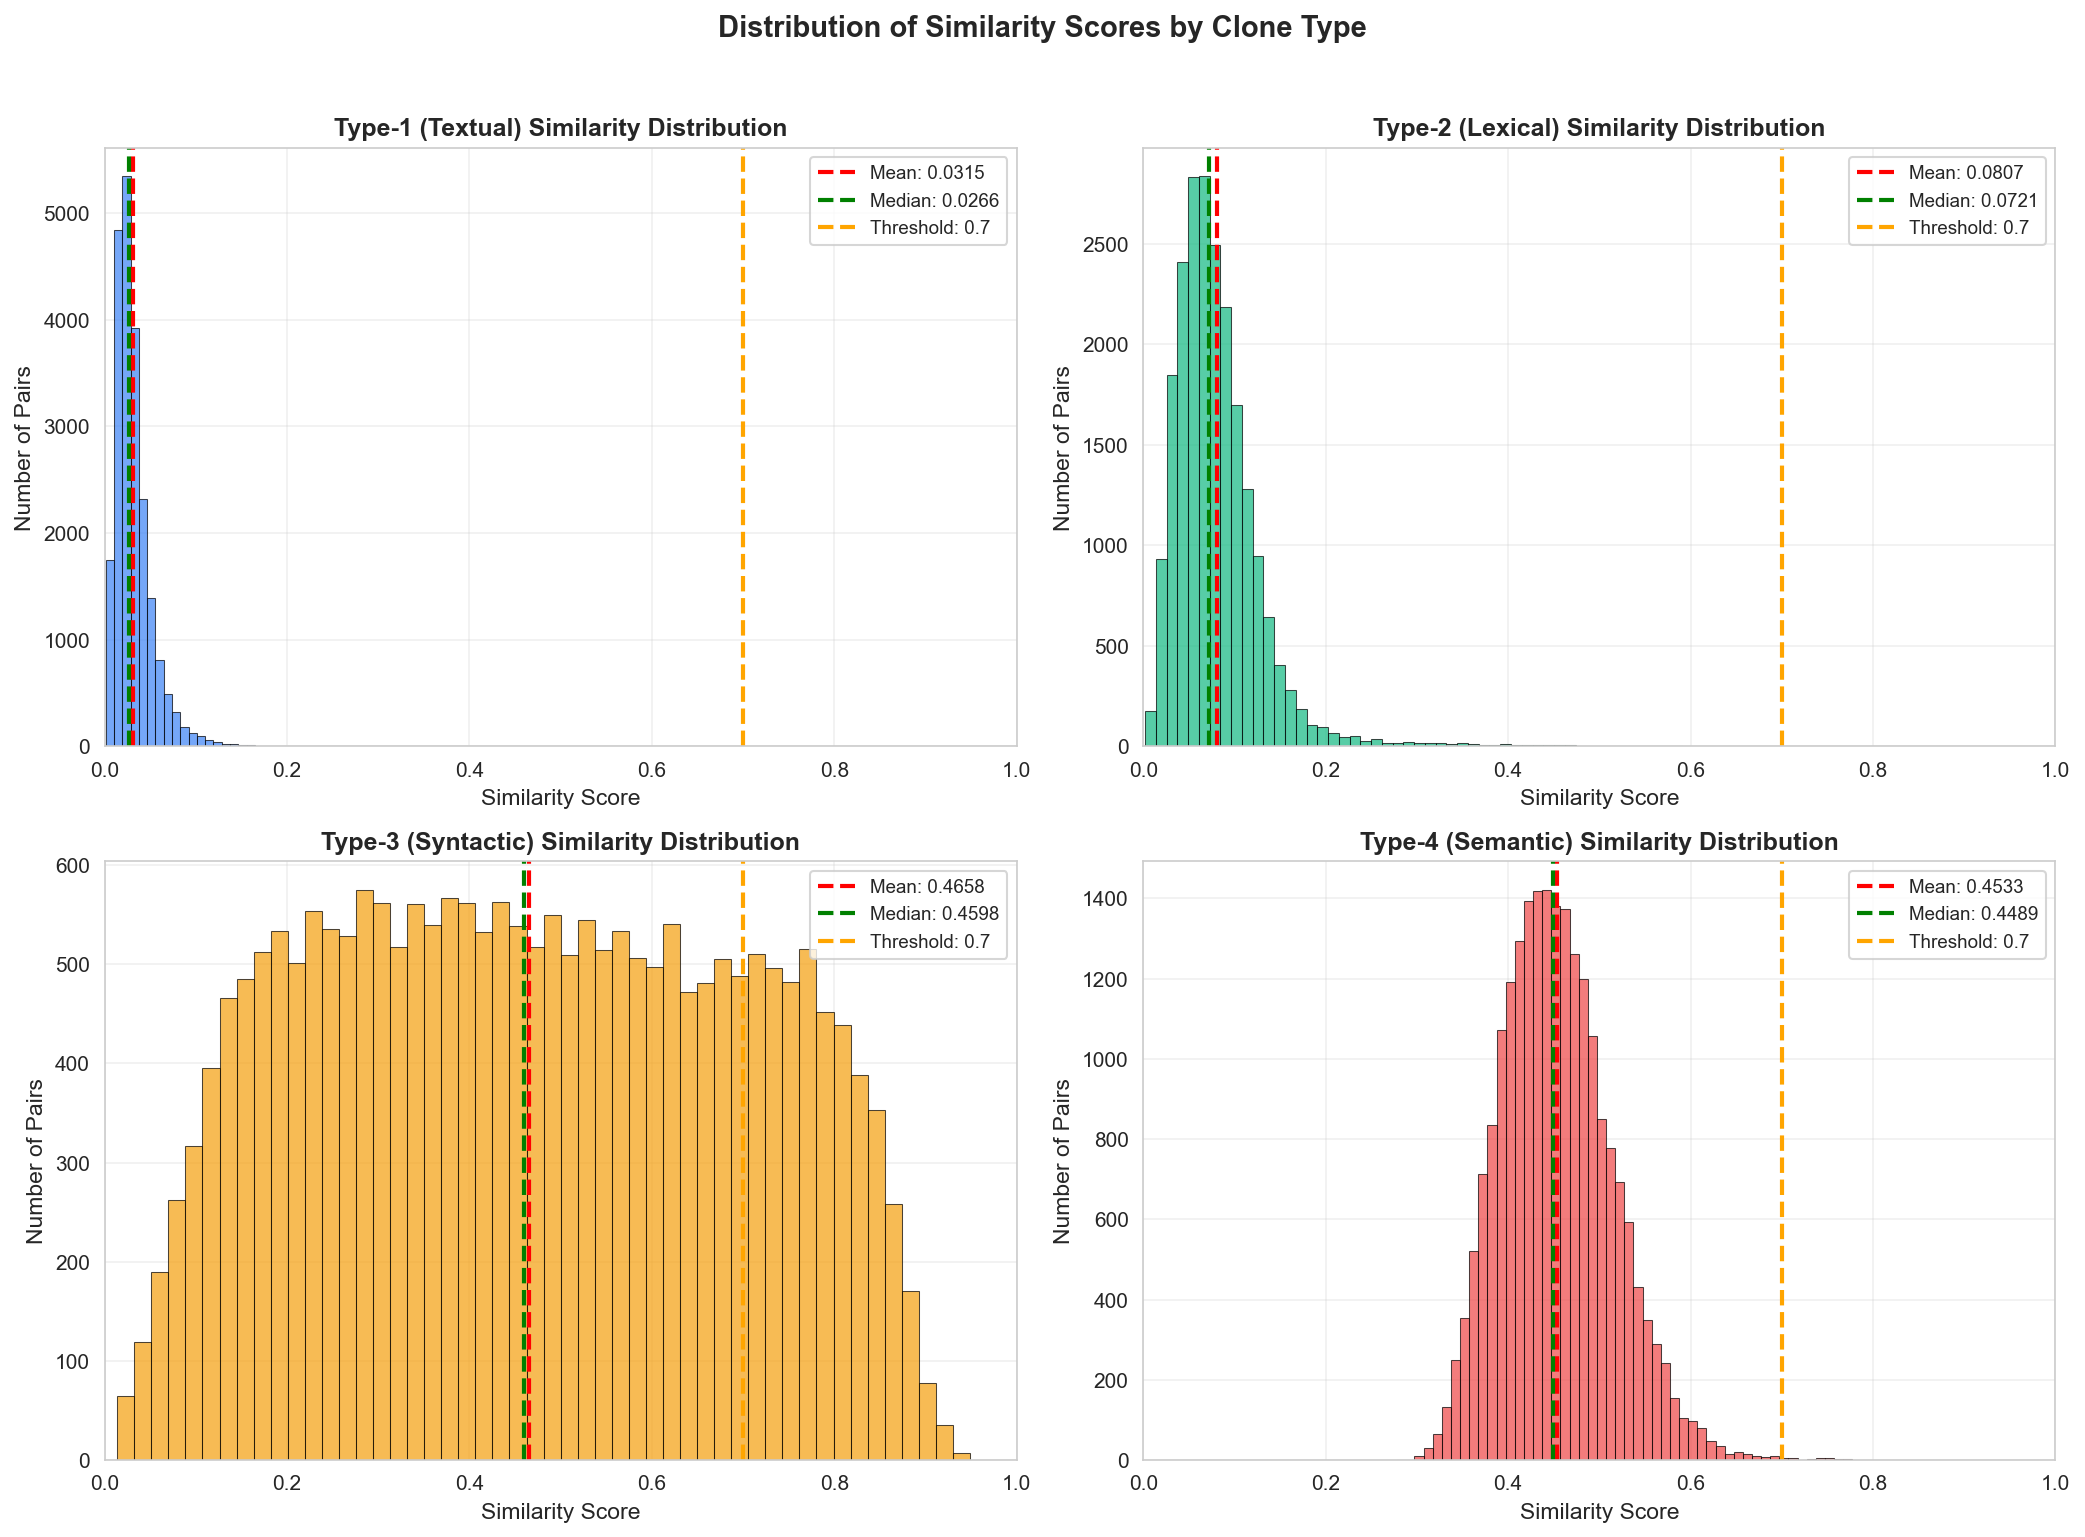

Saved: outputs/figures/clone_type_comparison.png
Saved: outputs/figures/clone_type_comparison.pdf


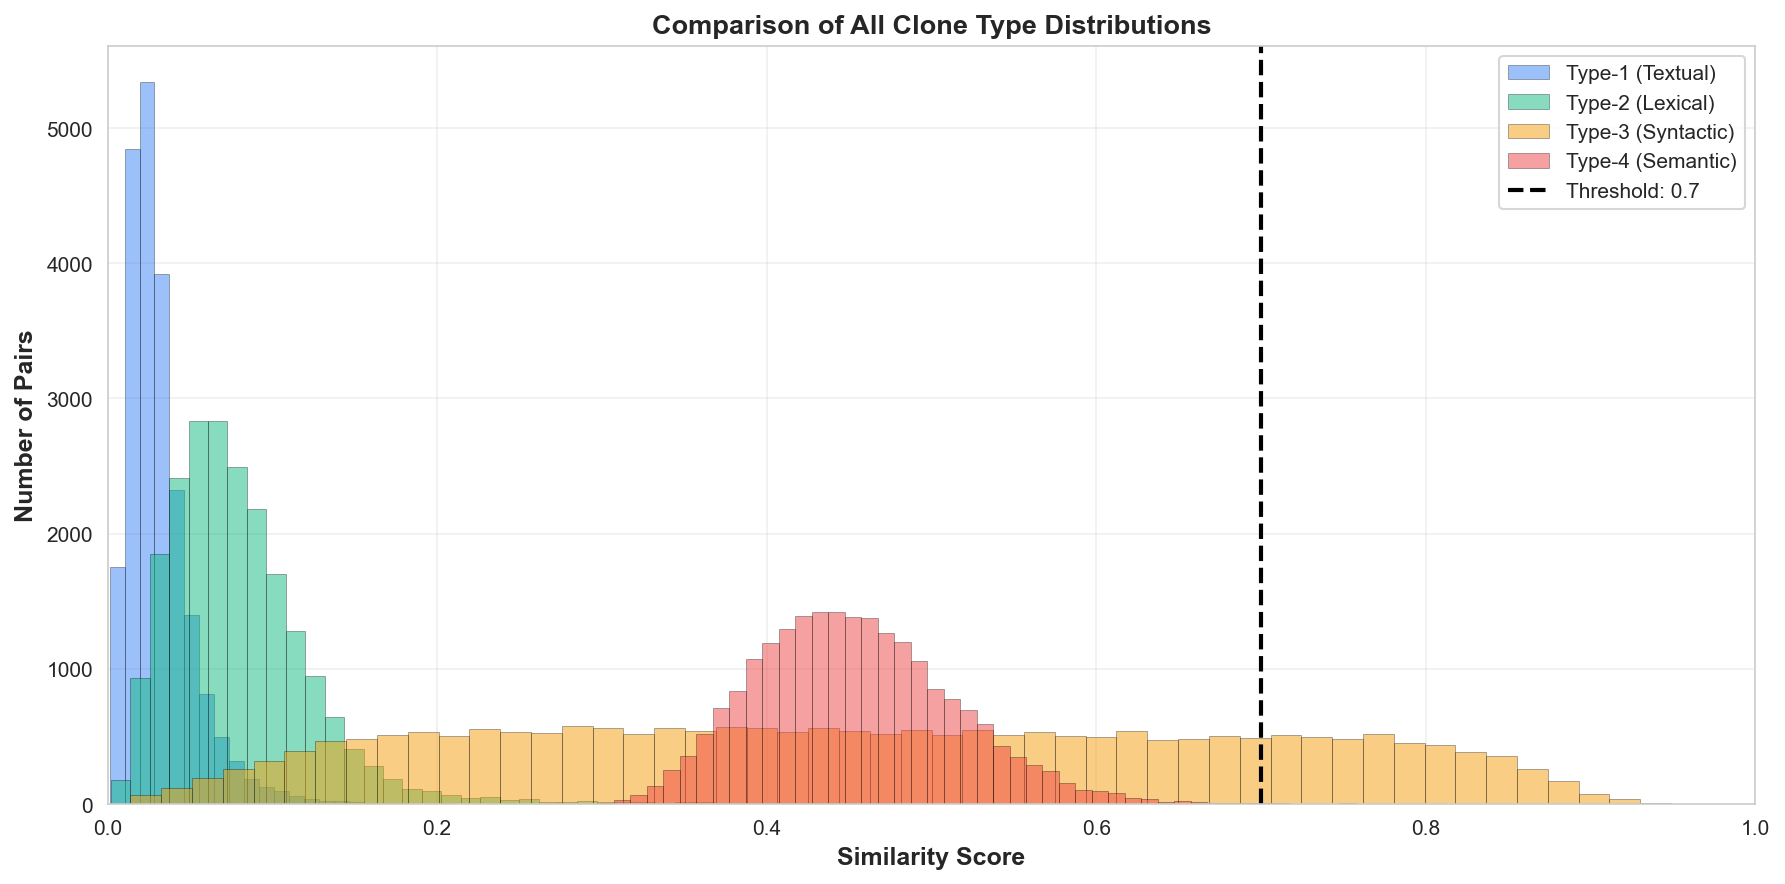

Saved: outputs/figures/high_similarity_counts.png
Saved: outputs/figures/high_similarity_counts.pdf


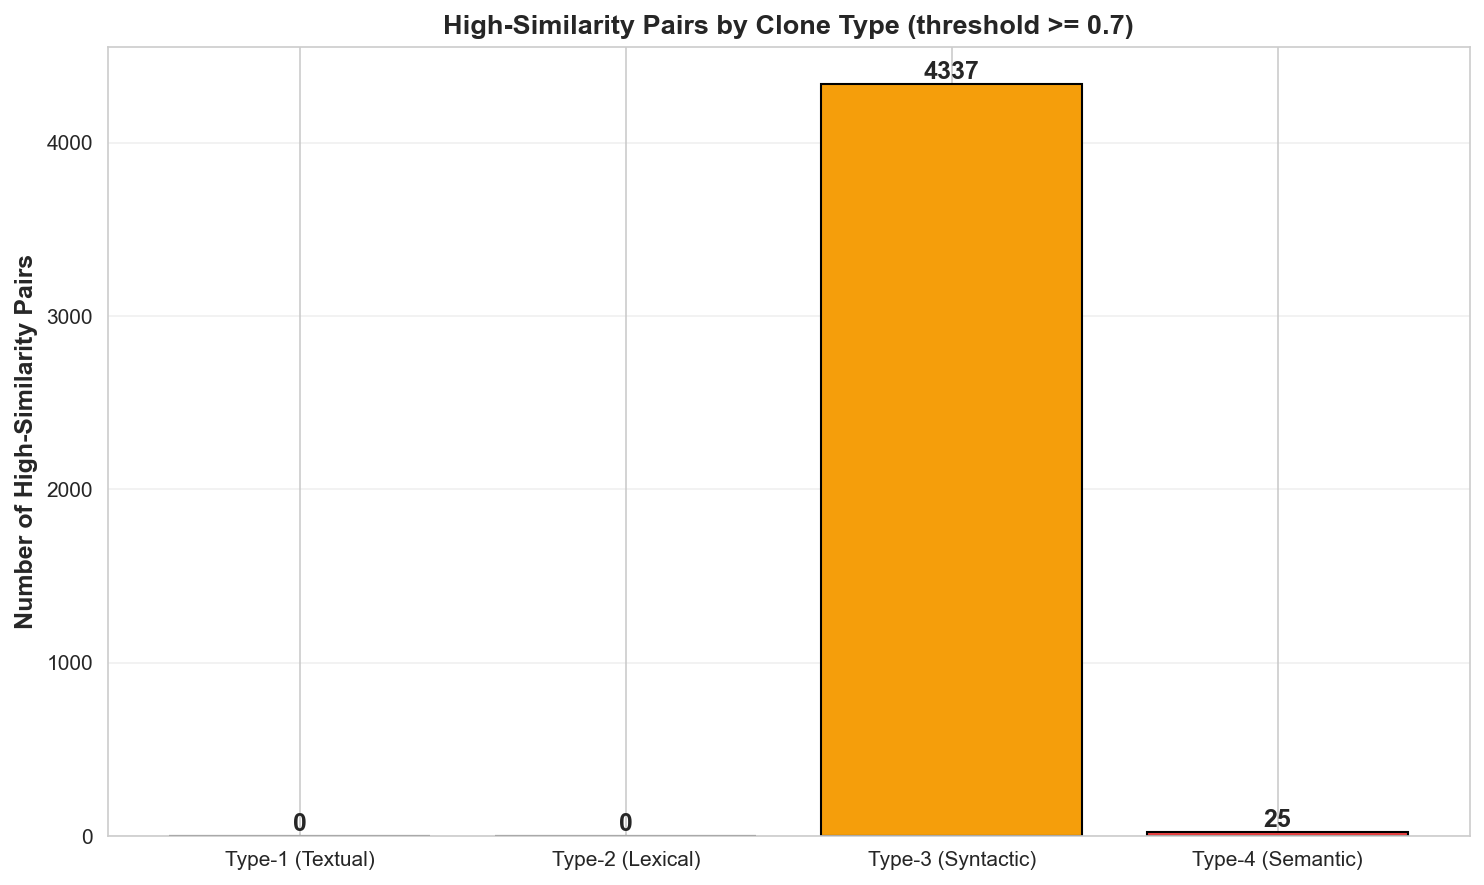


STEP 5.1 COMPLETE


In [ ]:
# Step 5.1: Similarity Score Distributions
# Visualizes the distribution of similarity scores for all 4 clone types

print("="*80)
print("STEP 5.1: SIMILARITY SCORE DISTRIBUTIONS")
print("="*80)

# Check if clone detection results exist
clone_results_path = 'outputs/clone_detection_all_pairs.csv'
if not os.path.exists(clone_results_path):
    raise FileNotFoundError(f"{clone_results_path} not found. Please run Step 3.2 (Clone Detection) first.")

# Load all similarity results
results_df = pd.read_csv(clone_results_path)
print(f"\nLoaded: {len(results_df):,} similarity pairs")

# Create output directory
os.makedirs('outputs/figures', exist_ok=True)

# Set style
sns.set_style("whitegrid")

# Clone type info
clone_types = {
    'type1_similarity': ('Type-1 (Textual)', '#3b82f6'),
    'type2_similarity': ('Type-2 (Lexical)', '#10b981'),
    'type3_similarity': ('Type-3 (Syntactic)', '#f59e0b'),
    'type4_similarity': ('Type-4 (Semantic)', '#ef4444')
}

HIGH_SIM_THRESHOLD = 0.7

# Print statistics for each type
print("\n" + "="*80)
print("STATISTICS BY CLONE TYPE")
print("="*80)

for col, (name, color) in clone_types.items():
    scores = results_df[col]
    high_count = (scores >= HIGH_SIM_THRESHOLD).sum()
    print(f"\n{name}:")
    print(f"  Mean:   {scores.mean():.4f}")
    print(f"  Median: {scores.median():.4f}")
    print(f"  Std:    {scores.std():.4f}")
    print(f"  Min:    {scores.min():.4f}")
    print(f"  Max:    {scores.max():.4f}")
    print(f"  High similarity (>= {HIGH_SIM_THRESHOLD}): {high_count} pairs ({high_count/len(scores)*100:.2f}%)")

# Create visualization: 2x2 grid of histograms
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (col, (name, color)) in enumerate(clone_types.items()):
    ax = axes[i]
    scores = results_df[col]
    
    # Histogram
    ax.hist(scores, bins=50, color=color, alpha=0.7, edgecolor='black', linewidth=0.5)
    
    # Add lines for mean, median, threshold
    ax.axvline(scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {scores.mean():.4f}')
    ax.axvline(scores.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {scores.median():.4f}')
    ax.axvline(HIGH_SIM_THRESHOLD, color='orange', linestyle='--', linewidth=2, label=f'Threshold: {HIGH_SIM_THRESHOLD}')
    
    ax.set_xlabel('Similarity Score', fontsize=11)
    ax.set_ylabel('Number of Pairs', fontsize=11)
    ax.set_title(f'{name} Similarity Distribution', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    ax.set_xlim(0, 1)

plt.suptitle('Distribution of Similarity Scores by Clone Type', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('outputs/figures/clone_type_distributions.png', dpi=300, bbox_inches='tight')
plt.savefig('outputs/figures/clone_type_distributions.pdf', bbox_inches='tight')
print(f"\nSaved: outputs/figures/clone_type_distributions.png")
print(f"Saved: outputs/figures/clone_type_distributions.pdf")
plt.show()

# Create combined histogram overlay
fig, ax = plt.subplots(figsize=(12, 6))

for col, (name, color) in clone_types.items():
    scores = results_df[col]
    ax.hist(scores, bins=50, alpha=0.5, label=name, color=color, edgecolor='black', linewidth=0.3)

ax.axvline(HIGH_SIM_THRESHOLD, color='black', linestyle='--', linewidth=2, label=f'Threshold: {HIGH_SIM_THRESHOLD}')
ax.set_xlabel('Similarity Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Pairs', fontsize=12, fontweight='bold')
ax.set_title('Comparison of All Clone Type Distributions', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.set_xlim(0, 1)

plt.tight_layout()
plt.savefig('outputs/figures/clone_type_comparison.png', dpi=300, bbox_inches='tight')
plt.savefig('outputs/figures/clone_type_comparison.pdf', bbox_inches='tight')
print(f"Saved: outputs/figures/clone_type_comparison.png")
print(f"Saved: outputs/figures/clone_type_comparison.pdf")
plt.show()

# Summary bar chart of high-similarity pairs
fig, ax = plt.subplots(figsize=(10, 6))

type_names = [name for name, color in clone_types.values()]
colors = [color for name, color in clone_types.values()]
high_counts = [(results_df[col] >= HIGH_SIM_THRESHOLD).sum() for col in clone_types.keys()]

bars = ax.bar(type_names, high_counts, color=colors, edgecolor='black', linewidth=1)

# Add count labels on bars
for bar, count in zip(bars, high_counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            str(count), ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Number of High-Similarity Pairs', fontsize=12, fontweight='bold')
ax.set_title(f'High-Similarity Pairs by Clone Type (threshold >= {HIGH_SIM_THRESHOLD})', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/figures/high_similarity_counts.png', dpi=300, bbox_inches='tight')
plt.savefig('outputs/figures/high_similarity_counts.pdf', bbox_inches='tight')
print(f"Saved: outputs/figures/high_similarity_counts.png")
print(f"Saved: outputs/figures/high_similarity_counts.pdf")
plt.show()


### Step 5.2: High Similarity Pairs Table

**Objective**: Display detailed information about high-similarity pairs.

**How it works**:
1. Group pairs by KEV exploit
2. Show CVE information for each pair
3. Display similarity scores

**Output**: Table of high-similarity exploit pairs.

In [115]:
# Step 5.2: High Similarity Pairs Table grouped by KEV Exploit

# Load high similarity pairs
with open('ast_similarity_results.json', 'r') as f:
    results = json.load(f)

high_sim_pairs = results['high_similarity_pairs']

# Group by KEV exploit
kev_groups = {}
for pair in high_sim_pairs:
    kev_id = pair['kev_id']
    if kev_id not in kev_groups:
        kev_groups[kev_id] = {
            'kev_cve': pair['kev_cve'],
            'matches': []
        }
    kev_groups[kev_id]['matches'].append({
        'non_kev_id': pair['non_kev_id'],
        'non_kev_cve': pair['non_kev_cve'],
        'similarity': pair['similarity']
    })

# Sort matches by similarity (descending) for each KEV
for kev_id in kev_groups:
    kev_groups[kev_id]['matches'].sort(key=lambda x: x['similarity'], reverse=True)

# Load metadata from exploit database CSV file
kev_exploit_metadata = {}
non_kev_metadata = {}

exploit_csv_path = 'outputs/Files/files_exploits.csv'
if os.path.exists(exploit_csv_path):
    try:
        exploit_df = pd.read_csv(exploit_csv_path)
        
        # Get all unique IDs from high similarity pairs
        all_kev_ids = set([pair['kev_id'] for pair in high_sim_pairs])
        all_non_kev_ids = set([pair['non_kev_id'] for pair in high_sim_pairs])
        
        # Load metadata for KEV exploits from exploit database
        for exploit_id in all_kev_ids:
            row = exploit_df[exploit_df['id'] == exploit_id]
            if len(row) > 0:
                r = row.iloc[0]
                kev_exploit_metadata[exploit_id] = {
                    'title': str(r.get('description', '')) if pd.notna(r.get('description')) else '',
                    'file': str(r.get('file', '')) if pd.notna(r.get('file')) else '',
                    'date_published': str(r.get('date_published', '')) if pd.notna(r.get('date_published')) else '',
                    'author': str(r.get('author', '')) if pd.notna(r.get('author')) else '',
                    'type': str(r.get('type', '')) if pd.notna(r.get('type')) else '',
                    'platform': str(r.get('platform', '')) if pd.notna(r.get('platform')) else '',
                    'source_url': str(r.get('source_url', '')) if pd.notna(r.get('source_url')) else ''
                }
        
        # Load metadata for non-KEV exploits
        for exploit_id in all_non_kev_ids:
            row = exploit_df[exploit_df['id'] == exploit_id]
            if len(row) > 0:
                r = row.iloc[0]
                non_kev_metadata[exploit_id] = {
                    'title': str(r.get('description', '')) if pd.notna(r.get('description')) else '',
                    'file': str(r.get('file', '')) if pd.notna(r.get('file')) else '',
                    'date_published': str(r.get('date_published', '')) if pd.notna(r.get('date_published')) else '',
                    'author': str(r.get('author', '')) if pd.notna(r.get('author')) else '',
                    'type': str(r.get('type', '')) if pd.notna(r.get('type')) else '',
                    'platform': str(r.get('platform', '')) if pd.notna(r.get('platform')) else '',
                    'source_url': str(r.get('source_url', '')) if pd.notna(r.get('source_url')) else ''
                }
        
        print(f"Loaded exploit metadata for {len(kev_exploit_metadata)}/{len(all_kev_ids)} KEV exploits and {len(non_kev_metadata)}/{len(all_non_kev_ids)} non-KEV exploits")
    except Exception as e:
        print(f"Warning: Could not load metadata from CSV: {e}")
else:
    print(f"Warning: Exploit database CSV not found at {exploit_csv_path}")

# Load KEV catalog metadata (from KEV database) based on CVE
kev_catalog_metadata = {}

# Try to access kev_df from globals
kev_df_local = None
try:
    kev_df_local = globals().get('kev_df')
except:
    pass

# If not available, try to reload KEV data using the same method as Step 5
if kev_df_local is None or len(kev_df_local) == 0:
    print("KEV database not available. Trying to load from saved file or download...")
    
    # First, try to load from a saved file
    kev_saved_paths = ['outputs/kev_data.json', 'kev_data.json', 'outputs/vulncheck_kev.json']
    loaded_from_file = False
    for path in kev_saved_paths:
        if os.path.exists(path):
            try:
                with open(path, 'r') as f:
                    all_kev_entries = json.load(f)
                    kev_df_local = pd.DataFrame(all_kev_entries)
                    print(f"  Loaded KEV data from {path} ({len(kev_df_local):,} entries)")
                    loaded_from_file = True
                    break
            except Exception as e:
                continue
    
    # If not loaded from file, try to download
    if not loaded_from_file:
        try:
            import zipfile
            import io
            import urllib3
            urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
            
            # Use the same API key as Step 5
            VULNCHECK_API_KEY = "vulncheck_a50222ddd96c3e8cdd7f7e1fd30f1bcf61afa60cd1304a5028f337067af88243"
            
            # Try to use vulncheck_sdk if available
            try:
                
                configuration = vulncheck_sdk.Configuration(host="https://api.vulncheck.com/v3")
                configuration.api_key["Bearer"] = VULNCHECK_API_KEY
                configuration.verify_ssl = False
                
                with vulncheck_sdk.ApiClient(configuration) as api_client:
                    endpoints_client = vulncheck_sdk.EndpointsApi(api_client)
                    api_response = endpoints_client.backup_index_get("vulncheck-kev")
                    
                    if api_response.data and len(api_response.data) > 0:
                        backup_url = api_response.data[0].url
                        
                        # Download the backup file
                        response = requests.get(backup_url, timeout=300, verify=False)
                        response.raise_for_status()
                        
                        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
                            json_files = [f for f in zip_file.namelist() if f.endswith('.json')]
                            if json_files:
                                with zip_file.open(json_files[0]) as f:
                                    all_kev_entries = json.load(f)
                                kev_df_local = pd.DataFrame(all_kev_entries)
                                print(f"  Downloaded {len(kev_df_local):,} KEV entries")
            except ImportError:
                print("  vulncheck_sdk not available, skipping download")
                print("  Please run Step 5 first to download KEV data, or save kev_df to a JSON file")
                
        except Exception as e:
            print(f"  Error downloading KEV data: {e}")
            print("  Please run Step 5 first to download KEV data")

if kev_df_local is not None and len(kev_df_local) > 0:
    # Get all unique CVEs from KEV exploits
    all_kev_cves = set()
    for pair in high_sim_pairs:
        cve = pair.get('kev_cve', '')
        if cve:
            # Handle multiple CVEs (comma-separated)
            cves = [c.strip() for c in str(cve).split(',')]
            all_kev_cves.update(cves)
    
    print(f"Looking for {len(all_kev_cves)} unique CVEs in KEV database...")
    
    # Load KEV catalog metadata for each CVE
    for cve in all_kev_cves:
        # Find KEV entry for this CVE
        found = False
        for idx, row in kev_df_local.iterrows():
            cve_list = row.get('cve', [])
            
            # Handle different formats of CVE column
            if pd.isna(cve_list):
                continue
            
            # Convert to list if needed
            if isinstance(cve_list, str):
                # Try to parse if it's a string representation of a list
                import ast
                try:
                    cve_list = ast.literal_eval(cve_list)
                except:
                    # If parsing fails, treat as single CVE string
                    cve_list = [cve_list]
            
            if not isinstance(cve_list, list):
                cve_list = [cve_list]
            
            # Normalize CVEs for comparison (uppercase, strip)
            cve_list_normalized = [str(c).upper().strip() for c in cve_list if c]
            cve_normalized = str(cve).upper().strip()
            
            if cve_normalized in cve_list_normalized:
                # Helper function to safely convert to string
                def safe_str(value, default=''):
                    if value is None or (isinstance(value, float) and pd.isna(value)):
                        return default
                    if isinstance(value, (list, tuple)):
                        return str(value) if value else default
                    return str(value)
                
                kev_catalog_metadata[cve] = {
                    'vendor_project': safe_str(row.get('vendorProject', '')),
                    'product': safe_str(row.get('product', '')),
                    'short_description': safe_str(row.get('shortDescription', '')),
                    'vulnerability_name': safe_str(row.get('vulnerabilityName', '')),
                    'required_action': safe_str(row.get('required_action', '')),
                    'known_ransomware_campaign_use': safe_str(row.get('knownRansomwareCampaignUse', '')),
                    'cwes': safe_str(row.get('cwes', '')),
                    'cisa_date_added': safe_str(row.get('cisa_date_added', '')),
                    'date_added': safe_str(row.get('date_added', ''))
                }
                found = True
                break
        
        if not found:
            print(f"  Warning: CVE {cve} not found in KEV database")
    
    print(f"Loaded KEV catalog metadata for {len(kev_catalog_metadata)}/{len(all_kev_cves)} CVEs")
    if len(kev_catalog_metadata) < len(all_kev_cves):
        missing = all_kev_cves - set(kev_catalog_metadata.keys())
        print(f"  Missing CVEs: {missing}")
else:
    print("Warning: Could not load KEV database")

# Create table rows - one row per KEV-match pair with metadata
table_rows = []
for kev_id, data in sorted(kev_groups.items(), key=lambda x: len(x[1]['matches']), reverse=True):
    matches = data['matches']
    kev_cve = data['kev_cve']
    kev_exploit_meta = kev_exploit_metadata.get(kev_id, {})
    
    # Get KEV catalog metadata for this CVE (use first CVE if multiple)
    kev_cve_list = [c.strip() for c in str(kev_cve).split(',')]
    primary_cve = kev_cve_list[0] if kev_cve_list else ''
    kev_catalog_meta = kev_catalog_metadata.get(primary_cve, {})
    
    for match in matches:
        non_kev_id = match['non_kev_id']
        non_kev_meta = non_kev_metadata.get(non_kev_id, {})
        
        table_rows.append({
            'KEV ID': kev_id,
            'KEV CVE': kev_cve,
            # KEV Exploit metadata (from exploit database)
            'KEV Title': kev_exploit_meta.get('title', ''),
            'KEV File': kev_exploit_meta.get('file', ''),
            'KEV Date Published': kev_exploit_meta.get('date_published', ''),
            'KEV Author': kev_exploit_meta.get('author', ''),
            'KEV Type': kev_exploit_meta.get('type', ''),
            'KEV Platform': kev_exploit_meta.get('platform', ''),
            'KEV Source URL': kev_exploit_meta.get('source_url', ''),
            # KEV Catalog metadata (from KEV database)
            'KEV Vendor Project': kev_catalog_meta.get('vendor_project', ''),
            'KEV Product': kev_catalog_meta.get('product', ''),
            'KEV Short Description': kev_catalog_meta.get('short_description', ''),
            'KEV Vulnerability Name': kev_catalog_meta.get('vulnerability_name', ''),
            'KEV Required Action': kev_catalog_meta.get('required_action', ''),
            'KEV Known Ransomware Campaign Use': kev_catalog_meta.get('known_ransomware_campaign_use', ''),
            'KEV CWEs': kev_catalog_meta.get('cwes', ''),
            'KEV CISA Date Added': kev_catalog_meta.get('cisa_date_added', ''),
            'KEV Date Added': kev_catalog_meta.get('date_added', ''),
            '# Matches': len(matches),
            'Non-KEV ID': non_kev_id,
            'Non-KEV CVE': match['non_kev_cve'],
            'Non-KEV Title': non_kev_meta.get('title', ''),
            'Non-KEV File': non_kev_meta.get('file', ''),
            'Non-KEV Date Published': non_kev_meta.get('date_published', ''),
            'Non-KEV Author': non_kev_meta.get('author', ''),
            'Non-KEV Type': non_kev_meta.get('type', ''),
            'Non-KEV Platform': non_kev_meta.get('platform', ''),
            'Non-KEV Source URL': non_kev_meta.get('source_url', ''),
            'Similarity': f"{match['similarity']:.6f}"
        })

# Create DataFrame and display
df = pd.DataFrame(table_rows)
print(f"\nHigh Similarity Pairs (>= 0.7): {len(high_sim_pairs)} pairs from {len(kev_groups)} KEV exploits\n")
print(df.to_string(index=False))

# Save to CSV (detailed format)
os.makedirs('outputs', exist_ok=True)
output_path = 'outputs/high_similarity_pairs_by_kev.csv'
df.to_csv(output_path, index=False)
print(f"\nSaved to: {output_path}")

# Also create a grouped CSV format (one row per KEV with all matches listed)
grouped_rows = []
for kev_id, data in sorted(kev_groups.items(), key=lambda x: len(x[1]['matches']), reverse=True):
    matches = data['matches']
    non_kev_ids = '; '.join([str(m['non_kev_id']) for m in matches])
    non_kev_cves = '; '.join([str(m['non_kev_cve']) for m in matches])
    similarities = '; '.join([f"{m['similarity']:.6f}" for m in matches])
    
    grouped_rows.append({
        'KEV ID': kev_id,
        'KEV CVE': data['kev_cve'],
        'Number of Matches': len(matches),
        'Non-KEV IDs': non_kev_ids,
        'Non-KEV CVEs': non_kev_cves,
        'Similarity Scores': similarities
    })

grouped_df = pd.DataFrame(grouped_rows)
grouped_output_path = 'outputs/high_similarity_pairs_by_kev_grouped.csv'
grouped_df.to_csv(grouped_output_path, index=False)
print(f"Grouped CSV saved to: {grouped_output_path}")

Loaded exploit metadata for 17/17 KEV exploits and 16/16 non-KEV exploits
Looking for 0 unique CVEs in KEV database...
Loaded KEV catalog metadata for 0/0 CVEs

High Similarity Pairs (>= 0.7): 25 pairs from 17 KEV exploits

 KEV ID KEV CVE                                                                      KEV Title                           KEV File KEV Date Published     KEV Author KEV Type KEV Platform                                                                                               KEV Source URL KEV Vendor Project KEV Product KEV Short Description KEV Vulnerability Name KEV Required Action KEV Known Ransomware Campaign Use KEV CWEs KEV CISA Date Added KEV Date Added  # Matches  Non-KEV ID Non-KEV CVE                                                                            Non-KEV Title                       Non-KEV File Non-KEV Date Published           Non-KEV Author Non-KEV Type Non-KEV Platform                                                                       

### Step 5.3: CVSS Score vs Similarity Correlation

**Objective**: Test whether exploit similarity correlates with vulnerability severity.

**How it works**:
1. Fetch CVSS scores from NVD API for each CVE
2. Plot similarity vs CVSS scores
3. Calculate Pearson and Spearman correlations

**What happens**:
- Downloads and caches CVSS scores
- Creates scatter plot with regression line
- Reports correlation statistics

**Output**: 
- Scatter plot of CVSS vs similarity
- Correlation test results

Loaded 21,828 similarity pairs
Loaded 46,950 ExploitDB entries
Unique CVEs to fetch CVSS for: 272
Need to fetch 272 new CVSS scores (0 cached)
   [10/272] Fetching...
   [20/272] Fetching...
   [30/272] Fetching...
   [40/272] Fetching...
   [50/272] Fetching...
   [60/272] Fetching...
   [70/272] Fetching...
   [80/272] Fetching...
   [90/272] Fetching...
   [100/272] Fetching...
   [110/272] Fetching...
   [120/272] Fetching...
   [130/272] Fetching...
   [140/272] Fetching...
   [150/272] Fetching...
   [160/272] Fetching...
   [170/272] Fetching...
   [180/272] Fetching...
   [190/272] Fetching...
   [200/272] Fetching...
   [210/272] Fetching...
   [220/272] Fetching...
   [230/272] Fetching...
   [240/272] Fetching...
   [250/272] Fetching...
   [260/272] Fetching...
   [270/272] Fetching...
   [272/272] Fetching...
CVSS scores available: 199/272 CVEs

CORRELATION ANALYSIS: CVSS Score vs Similarity

KEV CVSS (n=13,260 pairs):
  Pearson  r = +0.0111  (p = 2.03e-01)
  Spearman ρ = 

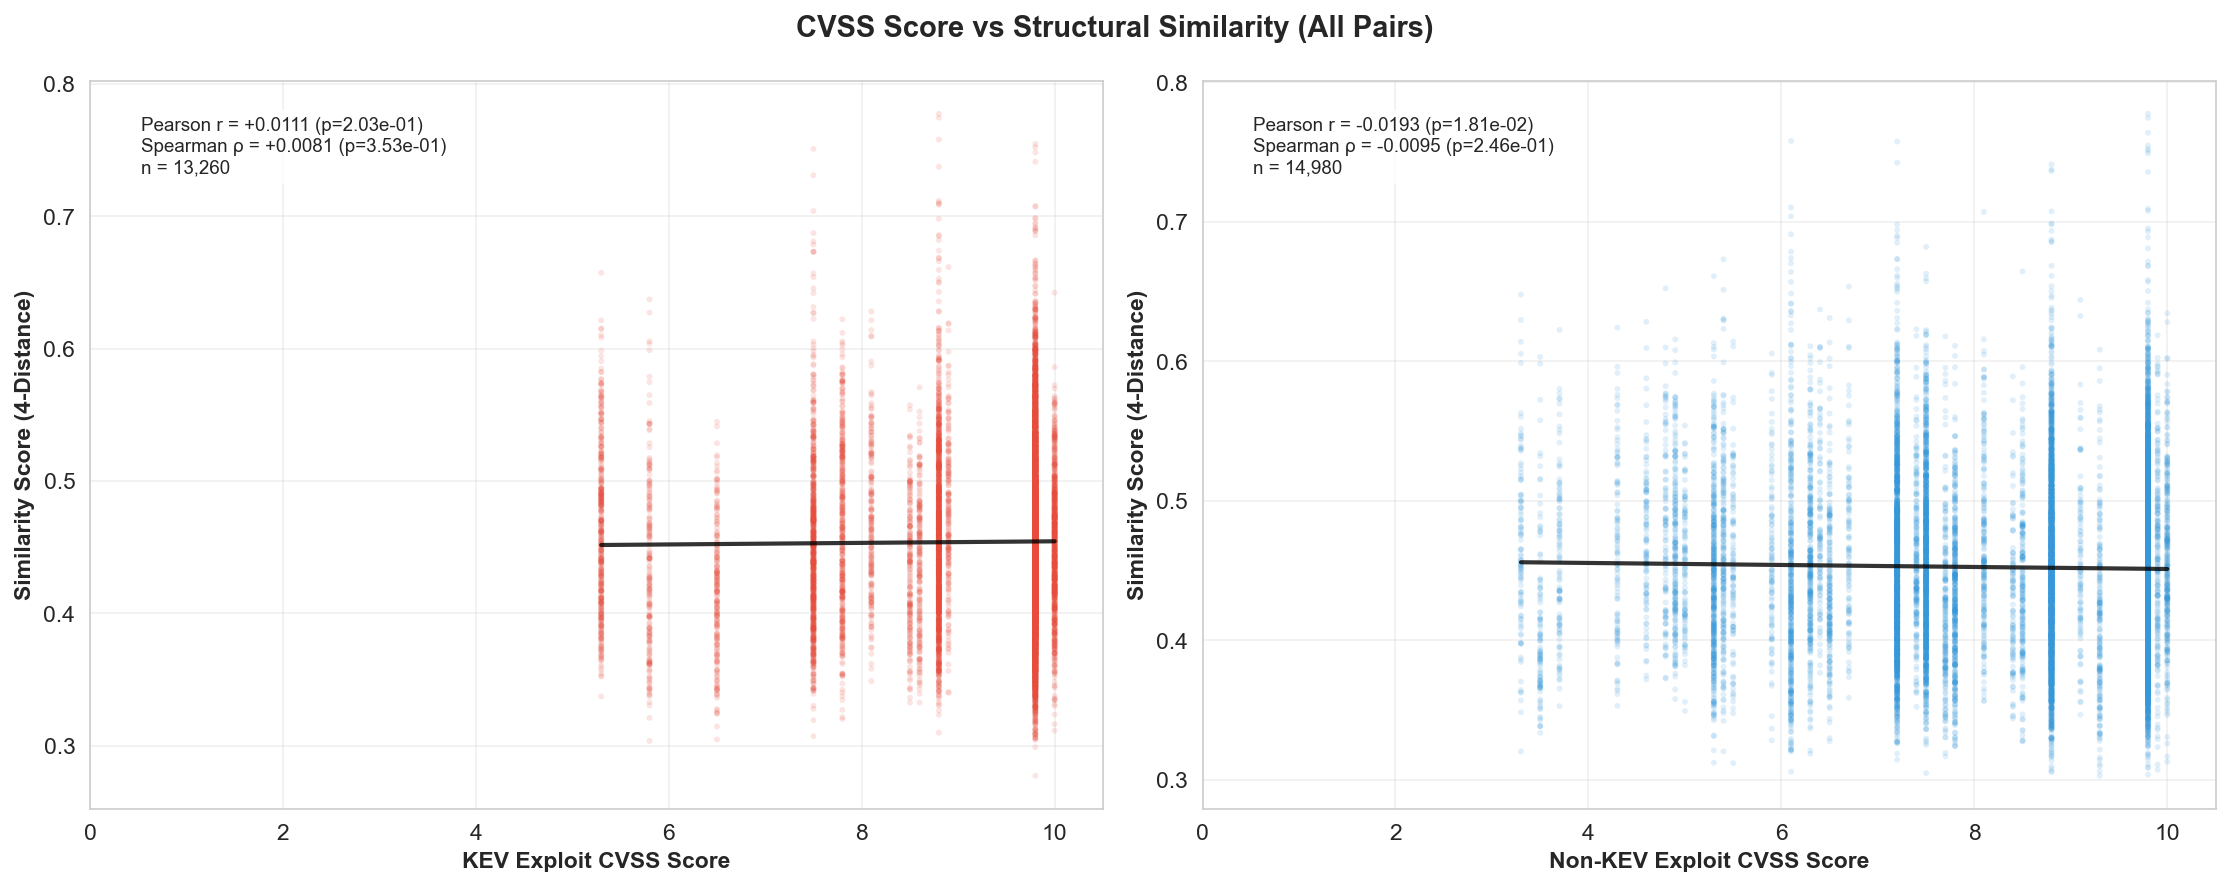


Saved to outputs/vis3_cvss_vs_similarity.pdf

Binned analysis: Average similarity per CVSS range

  KEV CVSS bins:
    Medium (4-7): mean=0.4448 ± 0.0629 (n=816)
    High (7-9): mean=0.4568 ± 0.0626 (n=3,468)
    Critical (9-10): mean=0.4537 ± 0.0605 (n=8,976)

  Non-KEV CVSS bins:
    Low (0-4): mean=0.4473 ± 0.0640 (n=321)
    Medium (4-7): mean=0.4567 ± 0.0629 (n=2,675)
    High (7-9): mean=0.4509 ± 0.0606 (n=7,169)
    Critical (9-10): mean=0.4529 ± 0.0628 (n=4,815)


In [116]:
# Step 5.3: CVSS Score vs Similarity — All Pairs

matplotlib.rcParams['font.size'] = 11
matplotlib.rcParams['figure.dpi'] = 150
os.makedirs('outputs', exist_ok=True)

# ─────────────────────────────────────────────
# 1. Load similarity pairs + exploit metadata
# ─────────────────────────────────────────────
sim_df = pd.read_csv('outputs/clone_detection_all_pairs.csv')
edb = pd.read_csv('outputs/Files/files_exploits.csv', encoding='latin-1')
print(f"Loaded {len(sim_df):,} similarity pairs")
print(f"Loaded {len(edb):,} ExploitDB entries")

# Map exploit ID → first CVE
def extract_first_cve(codes):
    if pd.isna(codes):
        return None
    matches = re.findall(r'CVE-\d{4}-\d{4,}', str(codes), re.IGNORECASE)
    return matches[0].upper() if matches else None

id_to_cve = {}
for _, row in edb.iterrows():
    cve = extract_first_cve(row.get('codes'))
    if cve:
        id_to_cve[row['id']] = cve

sim_df['kev_cve'] = sim_df['kev_id'].map(id_to_cve)
sim_df['non_kev_cve'] = sim_df['non_kev_id'].map(id_to_cve)

unique_cves = set(sim_df['kev_cve'].dropna()) | set(sim_df['non_kev_cve'].dropna())
print(f"Unique CVEs to fetch CVSS for: {len(unique_cves)}")

# ─────────────────────────────────────────────
# 2. Fetch CVSS scores (with local cache)
# ─────────────────────────────────────────────
CVSS_CACHE_FILE = 'outputs/cvss_cache.json'

# Load existing cache
if os.path.exists(CVSS_CACHE_FILE):
    with open(CVSS_CACHE_FILE, 'r') as f:
        cvss_cache = json_mod.load(f)
    print(f"Loaded {len(cvss_cache)} cached CVSS scores")
else:
    cvss_cache = {}

def get_cvss_from_nvd(cve_id, retries=2):
    """Fetch CVSS v3.x base score from NVD API"""
    url = f"https://services.nvd.nist.gov/rest/json/cves/2.0?cveId={cve_id}"
    for attempt in range(retries):
        try:
            r = requests.get(url, timeout=15)
            if r.status_code == 200:
                data = r.json()
                vulns = data.get('vulnerabilities', [])
                if vulns:
                    metrics = vulns[0].get('cve', {}).get('metrics', {})
                    for key in ['cvssMetricV31', 'cvssMetricV30']:
                        if key in metrics and metrics[key]:
                            return metrics[key][0]['cvssData']['baseScore']
                    if 'cvssMetricV2' in metrics and metrics['cvssMetricV2']:
                        return metrics['cvssMetricV2'][0]['cvssData']['baseScore']
                return None
            elif r.status_code == 403:
                time.sleep(6)
            else:
                return None
        except Exception:
            time.sleep(2)
    return None

# Fetch missing CVEs
to_fetch = [c for c in unique_cves if c not in cvss_cache]
print(f"Need to fetch {len(to_fetch)} new CVSS scores ({len(unique_cves) - len(to_fetch)} cached)")

for i, cve in enumerate(sorted(to_fetch), 1):
    if i % 10 == 0 or i == len(to_fetch):
        print(f"   [{i}/{len(to_fetch)}] Fetching...")
    score = get_cvss_from_nvd(cve)
    cvss_cache[cve] = score
    time.sleep(0.7)

# Save cache
with open(CVSS_CACHE_FILE, 'w') as f:
    json_mod.dump(cvss_cache, f, indent=2)

found = sum(1 for c in unique_cves if cvss_cache.get(c) is not None)
print(f"CVSS scores available: {found}/{len(unique_cves)} CVEs")

# Map to pairs
sim_df['kev_cvss'] = sim_df['kev_cve'].map(lambda c: cvss_cache.get(c) if pd.notna(c) else None)
sim_df['non_kev_cvss'] = sim_df['non_kev_cve'].map(lambda c: cvss_cache.get(c) if pd.notna(c) else None)

# ─────────────────────────────────────────────
# 3. Correlation analysis
# ─────────────────────────────────────────────
print("\n" + "="*70)
print("CORRELATION ANALYSIS: CVSS Score vs Similarity")
print("="*70)

results = []

for label, col in [('KEV CVSS', 'kev_cvss'), ('Non-KEV CVSS', 'non_kev_cvss')]:
    mask = sim_df[col].notna()
    n = mask.sum()
    if n > 2:
        x = sim_df.loc[mask, col].values
        y = sim_df.loc[mask, 'type4_similarity'].values
        r_pearson, p_pearson = pearsonr(x, y)
        r_spearman, p_spearman = spearmanr(x, y)
        results.append({
            'Metric': label, 'N pairs': n,
            'Pearson r': r_pearson, 'Pearson p': p_pearson,
            'Spearman ρ': r_spearman, 'Spearman p': p_spearman
        })
        print(f"\n{label} (n={n:,} pairs):")
        print(f"  Pearson  r = {r_pearson:+.4f}  (p = {p_pearson:.2e})")
        print(f"  Spearman ρ = {r_spearman:+.4f}  (p = {p_spearman:.2e})")
        sig_p = "YES" if p_pearson < 0.05 else "NO"
        sig_s = "YES" if p_spearman < 0.05 else "NO"
        print(f"  Significant (α=0.05)? Pearson: {sig_p}, Spearman: {sig_s}")

corr_df = pd.DataFrame(results)
corr_df.to_csv('outputs/vis3_cvss_correlation.csv', index=False)

# ─────────────────────────────────────────────
# 4. Scatter plots
# ─────────────────────────────────────────────
print("\nCreating plots...")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('CVSS Score vs Structural Similarity (All Pairs)', fontsize=14, fontweight='bold')

for ax, label, col, color in [
    (axes[0], 'KEV Exploit CVSS Score', 'kev_cvss', '#e74c3c'),
    (axes[1], 'Non-KEV Exploit CVSS Score', 'non_kev_cvss', '#3498db')
]:
    mask = sim_df[col].notna()
    if not mask.any():
        continue
    x = sim_df.loc[mask, col]
    y = sim_df.loc[mask, 'type4_similarity']

    ax.scatter(x, y, c=color, s=8, alpha=0.15, edgecolors='none')

    # Trend line
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    x_line = np.linspace(x.min(), x.max(), 100)
    ax.plot(x_line, p(x_line), '-', color='black', linewidth=2, alpha=0.8)

    # Correlation text
    r_p, p_p = pearsonr(x, y)
    r_s, p_s = spearmanr(x, y)
    ax.text(0.05, 0.95, f'Pearson r = {r_p:+.4f} (p={p_p:.2e})\nSpearman ρ = {r_s:+.4f} (p={p_s:.2e})\nn = {mask.sum():,}',
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    ax.set_xlabel(label, fontweight='bold')
    ax.set_ylabel('Similarity Score (4-Distance)', fontweight='bold')
    ax.set_xlim(0, 10.5)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/vis3_cvss_vs_similarity.pdf', bbox_inches='tight')
plt.savefig('outputs/vis3_cvss_vs_similarity.png', bbox_inches='tight', dpi=150)
plt.show()
print("\nSaved to outputs/vis3_cvss_vs_similarity.pdf")

# ─────────────────────────────────────────────
# 5. Binned analysis: average similarity per CVSS range
# ─────────────────────────────────────────────
print("\nBinned analysis: Average similarity per CVSS range")
for label, col in [('KEV', 'kev_cvss'), ('Non-KEV', 'non_kev_cvss')]:
    mask = sim_df[col].notna()
    if not mask.any():
        continue
    subset = sim_df.loc[mask].copy()
    subset['cvss_bin'] = pd.cut(subset[col], bins=[0, 4, 7, 9, 10], labels=['Low (0-4)', 'Medium (4-7)', 'High (7-9)', 'Critical (9-10)'])
    binned = subset.groupby('cvss_bin', observed=False)['type4_similarity'].agg(['mean', 'std', 'count'])
    print(f"\n  {label} CVSS bins:")
    for bin_name, row in binned.iterrows():
        if row['count'] > 0:
            print(f"    {bin_name}: mean={row['mean']:.4f} ± {row['std']:.4f} (n={int(row['count']):,})")

### Step 5.4: Payload Comparison (Side-by-Side)

**Objective**: Display actual exploit code for high-similarity pairs.

**How it works**:
1. For each high-similarity pair, fetch both exploit codes
2. Display side-by-side for manual comparison
3. Highlight similarities/differences

**Output**: Side-by-side code comparison for each high-similarity pair.

In [117]:
# Step 5.5: Payload Comparison (Side-by-Side)
# Display actual exploit code for high-similarity pairs

print("="*80)
print("STEP 5.5: PAYLOAD COMPARISON OF HIGH-SIMILARITY PAIRS")
print("="*80)

# Load high similarity pairs from Step 3.2
high_sim_path = 'outputs/high_similarity_type4.csv'
if not os.path.exists(high_sim_path):
    raise FileNotFoundError(f"{high_sim_path} not found. Run Step 3.2 first.")

high_sim_df = pd.read_csv(high_sim_path)
print(f"\nLoaded {len(high_sim_df)} high-similarity Type-4 pairs")

# Function to download exploit code
def download_exploit(file_path):
    """Download exploit code from ExploitDB GitLab"""
    if pd.isna(file_path) or not file_path:
        return None
    url = f"https://gitlab.com/exploit-database/exploitdb/-/raw/main/{file_path}"
    try:
        r = requests.get(url, timeout=15)
        return r.text if r.status_code == 200 else None
    except:
        return None

# Display pairs side-by-side
print("\n" + "="*80)
print("HIGH-SIMILARITY EXPLOIT PAIRS (Type-4 Semantic)")
print("="*80)

for i, row in high_sim_df.iterrows():
    print(f"\n{'='*80}")
    print(f"PAIR {i+1}: Similarity = {row['type4_similarity']:.4f}")
    print("="*80)
    
    print(f"\n[KEV] ID: {row['kev_id']} | File: {row['kev_file']}")
    print("-"*40)
    kev_code = download_exploit(row['kev_file'])
    if kev_code:
        # Show first 50 lines
        lines = kev_code.split('\n')[:50]
        for line in lines:
            print(line)
        if len(kev_code.split('\n')) > 50:
            print(f"\n... ({len(kev_code.split(chr(10)))} total lines)")
    else:
        print("(Could not download)")
    
    print(f"\n[NON-KEV] ID: {row['non_kev_id']} | File: {row['non_kev_file']}")
    print("-"*40)
    non_kev_code = download_exploit(row['non_kev_file'])
    if non_kev_code:
        lines = non_kev_code.split('\n')[:50]
        for line in lines:
            print(line)
        if len(non_kev_code.split('\n')) > 50:
            print(f"\n... ({len(non_kev_code.split(chr(10)))} total lines)")
    else:
        print("(Could not download)")
    
    # Only show first 10 pairs
    if i >= 9:
        remaining = len(high_sim_df) - 10
        if remaining > 0:
            print(f"\n\n... and {remaining} more pairs")
        break

print("\n" + "="*80)
print("STEP 5.5 COMPLETE")
print("="*80)

STEP 5.5: PAYLOAD COMPARISON OF HIGH-SIMILARITY PAIRS

Loaded 25 high-similarity Type-4 pairs

HIGH-SIMILARITY EXPLOIT PAIRS (Type-4 Semantic)

PAIR 1: Similarity = 0.7774

[KEV] ID: 47982 | File: exploits/php/webapps/47982.py
----------------------------------------
# Exploit Title: rConfig 3.9.3 - Authenticated Remote Code Execution
# Date: 2019-11-07
# CVE-2019-19509
# Exploit Author: vikingfr
# Vendor Homepage: https://rconfig.com/ (see also : https://github.com/rconfig/rconfig)
# Software Link : http://files.rconfig.com/downloads/scripts/centos7_install.sh
# Version: tested v3.9.3
# Tested on: Apache/2.4.6 (CentOS 7.7) OpenSSL/1.0.2k-fips PHP/7.2.24
#
# Notes : If you want to reproduce in your lab environment follow those links :
# http://help.rconfig.com/gettingstarted/installation
# then
# http://help.rconfig.com/gettingstarted/postinstall
#
# $ python3 rconfig_CVE-2019-19509.py https://192.168.43.34 admin root 192.168.43.245 8081
# rconfig - CVE-2019-19509 - Web authenticated R